In [1]:
# Portions of today's lesson were adapted from materials developed by Jack Bennetto and Matt Drury, 
# and from Jordi Warmenhoven's python solutions to ISRL labs.

# fredhutch.io -- Intermediate Python: Machine Learning
Fred Hutchinson Cancer Research Center

# Week 4 part 1 -- Dimensionality Reduction with PCA
Last week, we continued our study of supervised learning by looking at logistic regression and random forests in regression and classification. In part 1 of this week, we'll move over to unsupervised learning, considering first why we might want to represent a dataset using fewer dimensions than the original.

### By the end of part 1 of today's class, you should be able to:

 * Explain why we might want to create a lower-dimension representation of a dataset.
 * Explain the curse of dimensionality
 * Explain the conceptual basis of PCA (principal component analysis) and what is meant by subsequent PCs
 * Describe how PCA is used in practice and when to avoid using it.

### Throughout we've scattered pairs of cells like the 2 immediately below. Use them to note your thoughts, answers to questions, and the code you're experimenting with.
(remember that you can change the type of a cell by going into command mode (cell highlighted in blue) and pressing `m` for markdown and `y` for code)

__________
Notes (markdown):

In [2]:
# Scratch area (code)

Dimensionality Reduction
==========================================

**Consider:** The dimensionality of an object is the number of independent measurements that are needed to fully describe it.

### FIXME: I'd consider moving away from BMI as a highlighted example

For example, data on the **BMI** (body mass index) of a population sample might only include features regarding height and weight, resulting in a low dimensionality. In contrast, data from an **RNA-Seq** workflow might reasonably result in a gene expression features numbering in the hundreds of thousands, making the dimensionality of that dataset very high.

If a dataset has number of features which overlap or describe the related aspects, we might be able to *reduce the dimensionality of the problem* and in the process discovered a simpler description of the *same thing* or *very close to it*.

Let's consider why we might want to do that.

In [3]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from sklearn.datasets import load_iris, fetch_olivetti_faces
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix

# Always make it pretty.
plt.style.use('ggplot')

%matplotlib inline

### Reason to Reduce Dimensions #1:

To express a problem or describe an object in a more natural way.

### Example: Scatterplots in Cubes.

The **curse of dimensionality** is an unintuitive geometric phenomenon in high dimensional spaces.  Roughly it says

> The number of points needed to evenly sample an N-dimensional cube grows exponentially with N.

It sometimes helpful to say this in reverse

> If you have a fixed number of points of increasing dimension (i.e. you describe the points with more and more measurements), the average distance between the points grows with the number of dimensions.

### FIXME: "unit hypercubes of increasing dimension" - reword or add link

To illustrate, let's sample a fixed number of points from unit hypercubes of increasing dimension.

In [4]:
n_points = 1000
dimensions = range(1, 10)

# samples[dim] is a numpy array with shape (n_points, dim)
samples = {}
for dim in dimensions:
    samples[dim] = np.random.uniform(size=n_points*dim).reshape((n_points, dim))

For each of these samples, lets measure how much of the data lies inside a small cube of increasing size centered at a corner of the unit cube.

Like this for our two-dimensional data:

In [5]:
def num_points_within(sample, x):
    """Count the number of points in sample within a distance x of 
    the origin in each direction.
    """
    within = sample <= x
    all_within = np.all(within, axis=1)
    return np.sum(all_within)

Text(0, 0.5, 'N Points')

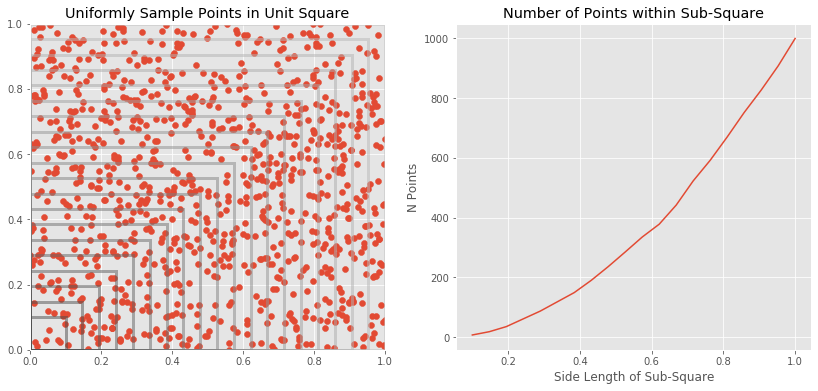

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

two_dim_data = samples[2]
ticks = np.linspace(0.1, 1, num=20)

ax = axs[0]
ax.scatter(two_dim_data[:, 0], two_dim_data[:, 1])
for edge_len in reversed(ticks):
    ax.add_patch(patches.Rectangle((0, 0), edge_len, edge_len, 
                                   color=cm.gray(0.25 + 0.5*edge_len), 
                                   linewidth=3, fill=False, alpha=0.5))
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_title("Uniformly Sample Points in Unit Square")

ax = axs[1]
density = [num_points_within(two_dim_data, edge_len) for edge_len in ticks]
ax.plot(ticks, density)
ax.set_title("Number of Points within Sub-Square")
ax.set_xlabel("Side Length of Sub-Square")
ax.set_ylabel("N Points")

The curve on the right shows how the number of points in a square changes as the size of the square increases to envelop the *entire* large square.

Not let's run this simulation but **change the dimension** of the larger square.

Text(0, 0.5, 'N Points')

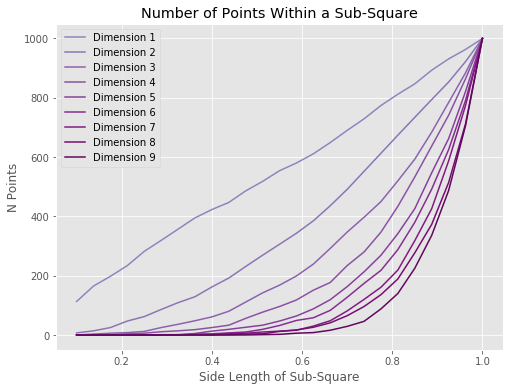

In [7]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ticks = np.linspace(0.1, 1, num=25)

for dim, sample in samples.items():
    density = [num_points_within(sample, edge_len) for edge_len in ticks]
    ax.plot(ticks, density, label="Dimension {}".format(dim), 
            color=cm.BuPu(0.5 + dim/20.0))
    
ax.legend(loc="upper left")
ax.set_title("Number of Points Within a Sub-Square")
ax.set_xlabel("Side Length of Sub-Square")
ax.set_ylabel("N Points")

In larger dimensions fewer and fewer of those data are *near* the fixed corner of the cube.

For algorithms that make predictions at $x$ by looking for training samples that are *near* $x$, we need an increasingly vast amount of data to construct accurate models.

### FIXME: need solution to discussion prompt

**Discussion:** What algorithms we have studied use only points *near* $x$ to make predictions or inferences about $x$.  Which do not have this property?

__________
Notes (markdown):

In [8]:
# Scratch area (code)

### Reason to Reduce Dimensions #2:

To combat the curse of dimensionality.

### Example: Visualization of Data

In Fischer's classic iris dataset, we describe flowers by four measurements, so it is a four dimensional representation of the flowers.

![Iris Measurements](../img/iris-measurements.png)

In [9]:
iris = load_iris()
iris_data = pd.DataFrame(iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_type = iris.target
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Data of dimension larger than *two* leads to challenges for visualization.  In dimension three we can draw some plots, but they are hard to use.  In dimension four, we need **coping strategies**.

**One option** is to plot each feature against each other feature in a scatter plot.

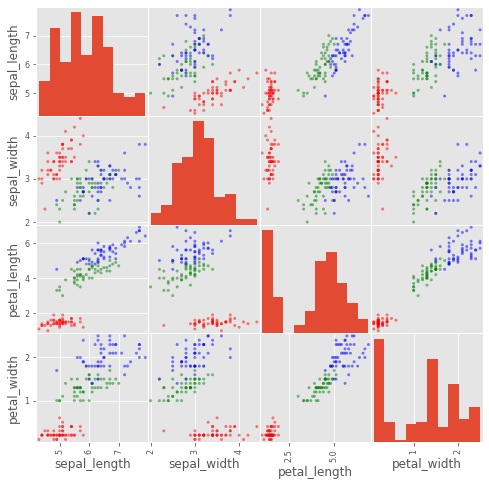

In [10]:
_ = scatter_matrix(iris_data, 
                   c=np.array(["red", "green", "blue"])[iris_type], 
                   figsize=(8, 8))

**Discussion:** How can we construct *one* scatterplot of the four-dimensional data that is in some sense the *best* way to represent it.

__________
Notes (markdown):

In [11]:
# Scratch area (code)

### Reason to Reduce Dimensions #3:

To compensate for our inability to visualize high dimensional situations.

### Introduction to Principal Component Analysis

Let's think of our data as a point cloud in $p$-dimensional space, and ask the following question:

**Fundamental Question:** How can we find a 1-dimensional data set $X_1$ so that

  - Going from $X$ to $X_1$ is a very simple operation.
  - In some sense, $X_1$ is the *best* one dimensional reconstruction of $X$.

### FIXME: Need answer to discussion prompt

**Discussion:** Consider "Going from $X$ to $X_1$ is a very simple operation".  What are some good candidates for *simple operations*.  The following animation may be suggestive.

![Pca Animation](../img/pca.gif)

Image source: http://stats.stackexchange.com/a/140579/74500

#### One-Dimensional PCA

We look for a **line** so that the *projection* of the data $X$ onto that line

  - Results in points minimizing the total orthogonal (perpendicular) squared distance to $X$
  - Results in points with *maximum variance* as a 1-dimensional data set.

In [1]:
n_points = 75

In [13]:
def random_data_set(n=n_points):
    theta = np.random.uniform(low=0, high=2*3.14159)
    rotation = np.array([[np.cos(theta), np.sin(theta)], 
                         [-np.sin(theta), np.cos(theta)]])
    data = np.column_stack([np.random.normal(size=n), 2*np.random.normal(size=n)])
    rotated_data = data @ rotation
    return rotated_data

In [14]:
def plot_1dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component line through the orgin (green).
        - Plot the eigenvector representing the principal component (black).
        - The point cloud projected onto the principal component line (green).
    """
    X = random_data_set()
    pcd = PCA(1).fit(X)
    e = pcd.components_[0]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a line for the principal component.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e[0]*x, e[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the line.
    X_proj = X @ e
    X_reconst = np.array([t*e for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e[0], e[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

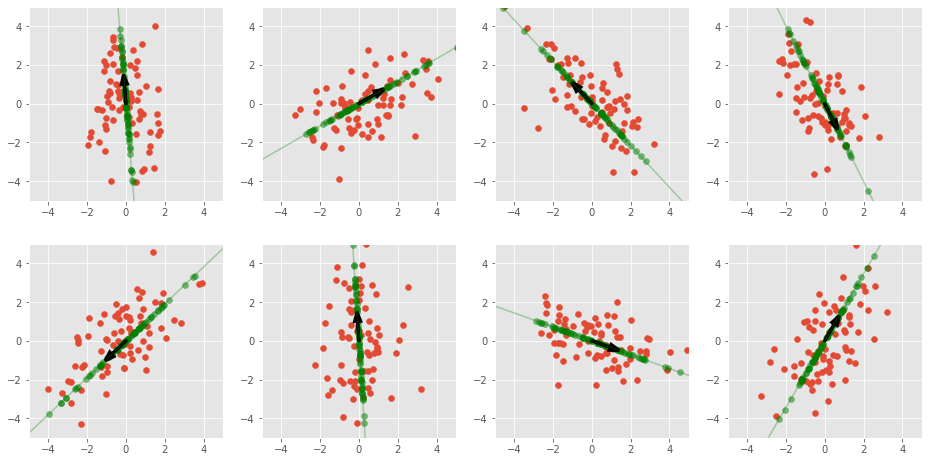

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_1dim_pca(ax)

In the above plots, we superimpose the first principal component onto a random scatter plot.  Notice that:

> The green line is chosen so that the projections of the data points onto this line are **maximally spread out**.

The direction of this line is called the **first principal component** of the data.

### FIXME: Need solution to discussion prompt

**Discussion:** How should we find the **second** principal component of the data set?

__________
Notes (markdown):

In [16]:
# Scratch area (code)

#### General Principal Components

**In general** PCA applied to a dataset $X$ returns the best line, plane, 3-space, 4-space, ... so that when $X$ is projected into the subspace

  - The total squared distance from the original data to the projections in minimized.
  - The total variance (i.e. the sum of the variances in all posible orthogonal directions) of the projected dataset is maximal.

In [17]:
def plot_2dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component lines through the orgin (green).
        - The eigenvectors representing the principal components (black).
        - The point cloud projected onto the principal component lines (green).
    """
    X = random_data_set()
    pcd = PCA(2).fit(X)
    e_1 = pcd.components_[0]
    e_2 = pcd.components_[1]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a lines for the principal components.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e_1[0]*x, e_1[1]*x, color='green', alpha=0.3, linestyle='-')
    ax.plot(e_2[0]*x, e_2[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the first line.
    X_proj = X @ e_1
    X_reconst = np.array([t*e_1 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot the projections of the data points onto the second line.
    X_proj = X @ e_2
    X_reconst = np.array([t*e_2 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e_1[0], e_1[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.arrow(0, 0, e_2[0], e_2[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

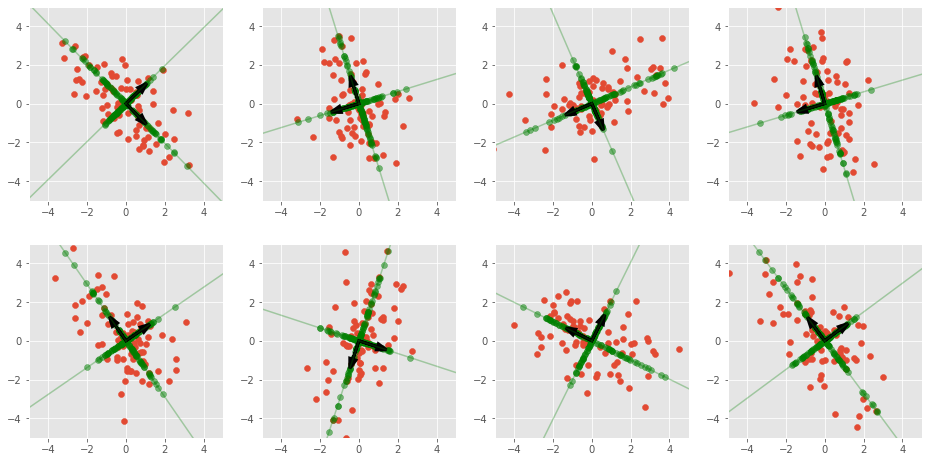

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_2dim_pca(ax)

In the above plots, we superimpose the first and second principal components onto a random scatter plot.  Notice that:

  - The **first principal component** determines a green line that maximizes the variance of the data's projection.
  - The **second principal component** is orthogonal to the first, and maximizes the projection of the "leftover" data.

### FIXME: never shows the 1-d principle component plot

__________
Notes (markdown):

In [19]:
# Scratch area (code)

### For Later Consideration: Computing Principal Components

### FIXME: Link out eigenvalue/eigenvector definition

The solution to the problem of finding principal components involves, somewhat surprisingly, the *eigenvalues* and *eigenvectors* of the covariance matrix $\frac{1}{n} X^t X$ of $X$.

**Note:** X must be centered before computing the covariance in this manner.

#### Setup:

$X$ is a dataset, which we represent as a $n \times p$ matrix of numbers.

In [20]:
X = random_data_set(n=50)
X[:5, :]

array([[-0.5488468 ,  0.63091204],
       [ 0.31912617,  1.74028895],
       [-1.04213676, -1.58927639],
       [-3.58335091,  2.52874731],
       [ 4.63645346, -0.16737093]])

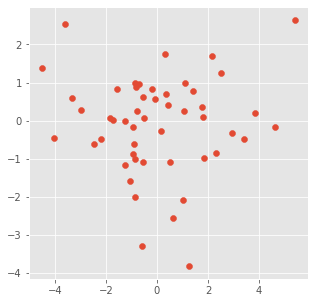

In [21]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1])

#### Step 1: Center the Matrix.

**Centering** the matrix is the process of subracting the column means from the columns themselves.  This results in a new matrix with column means zero.

In [22]:
np.mean(X, axis=0)

array([-0.01969083, -0.08135507])

In [23]:
X_centered = X - np.mean(X, axis=0)
print(np.mean(X_centered, axis=0))

[-1.24344979e-16 -8.88178420e-18]


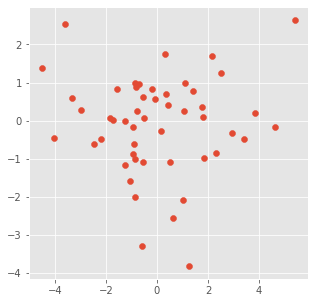

In [24]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1])

#### Step 2: Compute the sample covariance matrix.

The covariance matrix of the sample is $M = \frac{1}{n} X^t X$.

In [25]:
M = X.T @ X * (1/float(X.shape[0]))
M

array([[4.41462158, 0.02766265],
       [0.02766265, 1.65265987]])

The diagonal terms of the covariance matrix are the variance of the first and second columns. The cross terms show the interactions, showing how much the mean of one feature changes with a change in the mean of another.

#### Step 3: Compute the Eigenvectors and Eigenvalues of M.

The eigenvectors, when ordered in order of decreasing eigenvalue, are the principal components of $X$.

**Note:**
  - Since $M$ is a symmetric, it has a full set of $p$ eigenvectors.
  - Since $M$ is non-negative definite,  the eigenvalues are non-negative numbers.

In [26]:
e_values, e_vectors = eig(M)
print("The eigenvectors of M are:")
print(e_vectors)
print("The eigenvlaues of M are {}".format(e_values))

The eigenvectors of M are:
[[ 0.99994986 -0.01001407]
 [ 0.01001407  0.99994986]]
The eigenvlaues of M are [4.41489861 1.65238284]


__________
Notes (markdown):

In [27]:
# Scratch area (code)

### For Later Consideration: Eigenvectors

### FIXME: This section is way over my head.

Recall that the **eigenvectors** of $M$ are vectors $v$ that satisfy a relationship like:

$$ M v = \lambda v $$

I.e., the matrix $M$ acts as a **scaling** on the vector $v$.

In [28]:
(M @ e_vectors[:, 0]) / e_vectors[:, 0]

array([4.41489861, 4.41489861])

In [29]:
(M @ e_vectors[:, 1]) / e_vectors[:, 1]

array([1.65238284, 1.65238284])

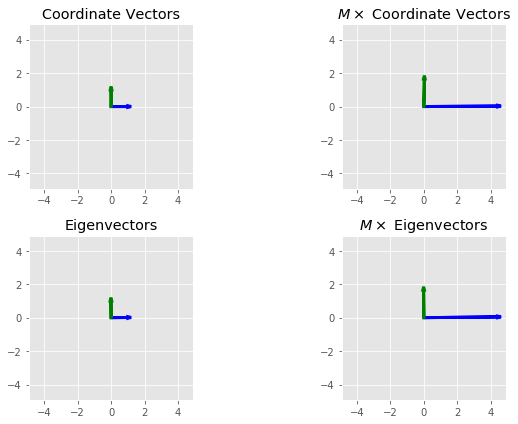

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), )

coord_vectors = np.array([[1, 0], [0, 1]])
coord_image = M @ coord_vectors
e_image = M @ e_vectors

# Set coordinate ranges to the maximal possible arrow position
max_coord = max(np.max(coord_vectors), np.max(coord_image), np.max(e_image))
for ax in axs.flatten():
    ax.set_xlim(-max_coord - 0.5, max_coord + 0.5)
    ax.set_ylim(-max_coord - 0.5, max_coord + 0.5)
    ax.set(adjustable='box', aspect='equal')


# Plot the coordiante vectors and thier images.
axs[0, 0].arrow(0, 0, coord_vectors[0, 0],  coord_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 0].arrow(0, 0, coord_vectors[0, 1], coord_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 0].set_title("Coordinate Vectors")
axs[0, 1].arrow(0, 0, coord_image[0, 0],  coord_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 1].arrow(0, 0, coord_image[0, 1], coord_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 1].set_title("$M \\times$ Coordinate Vectors")


# Plot the eigenvectors and thier images.
axs[1, 0].arrow(0, 0, e_vectors[0, 0],  e_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 0].arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 0].set_title("Eigenvectors")
axs[1, 1].arrow(0, 0, e_image[0, 0],  e_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 1].arrow(0, 0, e_image[0, 1], e_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 1].set_title("$M \\times$ Eigenvectors")

plt.tight_layout()

Above, we see that the effect of multiplying the matrix $M$ by coordinate vectors is difficult to understand, the coordinate vectors are rotated and scaled, each by a different amount.

On the other hand, the eigenvectors of $M$ are much better behaved when multiplied by $M$, the direction of the eigenvectors are preserved, but they are stretched or shrunk.

Let's plot the eigenvectors of $M$ on top of the centered data set to see how they relate to the scatterplot of the data

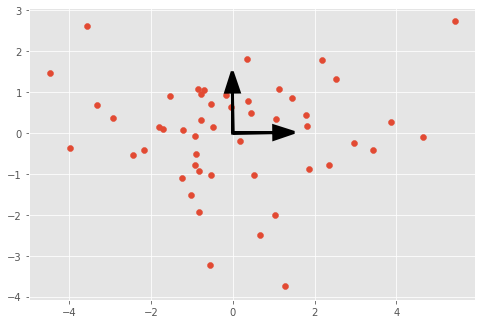

In [31]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(X_centered[:, 0], X_centered[:, 1])
ax.arrow(0, 0, e_vectors[0, 0], e_vectors[1, 0],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
ax.arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
_ = ax.set(adjustable='box', aspect='equal')

### FIXME: This section is really statistics dense. Needs to be simplified, broken down or better explained

### Summary:

  - The Principal Components algorithm computes the *eigenvectors* and *eigenvalues* of the matrix $X^t X$.
  - Each eigenvector is called a *principal component* of $X$.
  - Projecting onto the first $k$ principal components creates the **best k dimensional reconstruction of the data**.

__________
Notes (markdown):

In [32]:
# Scratch area (code)

## PCA In Practice

In practice, we can use `sklearn.decomposition.PCA` to find principal components.

In [33]:
pcd = PCA(2).fit(X)

Sklearn returns a `PCA` returns an object with a `components_` attribute.

In [34]:
pcd.components_

array([[ 0.9999557 ,  0.00941309],
       [ 0.00941309, -0.9999557 ]])

The `components_` attribute is an orthogonal matrix containing (as rows) the eigenvalues of the correlation matrix.  That is, the *principal components*.

Let's call the matrix of principal components $E$.

### Properties of Principal Components

1. Taking the first $k$ rows of $E$ gives (a basis for) the "best" $k$ dimensional subspace.  We call this subset matrix $E_{1:k}$.

2. "Best" above means: projecting the dataset onto this subspace preserves the **most variance in the data** out of all possible such projections.

3. The matrix multiplication $XE_{1:k}^t$ gives the *coefficients* of the "best" reconstruction of $X$ in the basis $E_k$.

4. The matrix multiplication $(X E_{1:k}^t) E_{1:k}$ gives the "best" reconstruction of $X$ as a $k$ dimensional object.  That is, this reconstructs $X$ as a matrix with $k$ columns.

Additionally, the `explained_variance_` attribute contains the total variance of the *projected* dataset.

Each of the numbers in `explained_variance_` is an *eigenvalue* of the covariance matrix $X^t X$.

5. The **eigenvalues** of the covariance matrix measure the variance of the projection of the data onto the associated eigenvector (principal component).

### FIXME: need solution to exercise

**Exercise:** Using the $X$ data above, what fraction of the variance is explained by the first principal component.

__________
Notes (markdown):

In [35]:
# Scratch area (code)

### FIXME: PCA section is very sparse on text. If this is to be all online might need more context

### What Principal Component Analysis IS For

So, **the purpose of PCA is to approximately reconstruct data sets as a lower dimensional object.**

Applications of this include:

  - Visualization.
  - Clustering.
  - Data Compression.
  - Mathematical analysis of the properties of regression modeling.

### Example: The Best Scatterplot of Iris

Let's construct a "best" scatterplot of the iris dataset using PCA to project

```
Four dimensional iris data => Best two dimensional reconstruction
                           => Best two dimensional scatterplot
```

In terms of the above discussion we are plotting the *expression of $X$ in the principal component basis*.

$$ X E_{1:2}^t $$

In [36]:
pcd = PCA(2).fit(iris_data.values)
iris_reduced = iris_data.values @ pcd.components_.T

Text(0, 0.5, 'Second Principal Component')

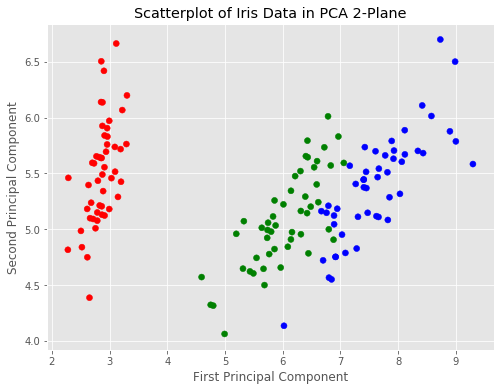

In [37]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(iris_reduced[:, 0], iris_reduced[:, 1], 
           color=np.array(["red", "green", "blue"])[iris_type])
ax.set_title("Scatterplot of Iris Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

### FIXME: Need solution for discussion prompt

**Discussion:** Does PCA find the plane in which the different categories are the most clearly distinguished?

__________
Notes (markdown):

In [38]:
# Scratch area (code)

### Example: Eigenfaces: Reconstructing Faces.

### FIXME: Add some info about the faces dataset

As an example of *very* high dimensional data, we introduce the `faces` data set.

An extended version of this example is available in the sklearn docs here: http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [39]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=154)
faces = dataset.data

n_samples, n_features = faces.shape

# Global centering
faces_centered = faces - faces.mean(axis=0)

# Local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [40]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

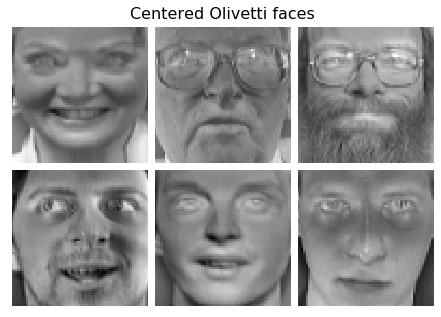

In [41]:
plot_gallery("Centered Olivetti faces", faces_centered[:n_components])

Each of these images is stored as a numpy array.

Each entry in the array measures *one* pixel intensity.

[[-0.05288465 -0.07872145 -0.09184127 ... -0.07057048  0.0761445
   0.11743565]
 [-0.03018858 -0.04831843 -0.0698887  ... -0.06516771  0.05821054
   0.10930555]
 [-0.03242992 -0.08290516 -0.05704789 ... -0.07283308  0.0611238
   0.10700177]
 ...
 [ 0.54305553  0.53032815  0.52888185 ...  0.46428466  0.43686754
   0.41230136]
 [ 0.5304936   0.52165043  0.5205554  ...  0.46218783  0.4446876
   0.4059273 ]
 [ 0.5239751   0.5176527   0.51337576 ...  0.4555865   0.44682604
   0.40869588]]


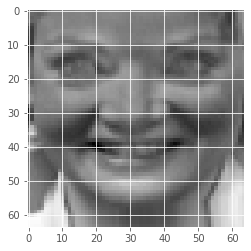

In [42]:
first_face = faces_centered[0].reshape(image_shape)
print(first_face)
plt.imshow(first_face, cmap=cm.gray)

Don't believe me?

### FIXME: Explain what is happening in the code below

In [43]:
first_face_ascii = np.array(['#', '.'])[(first_face >= 0).astype(int).flatten()].reshape(image_shape)
print('\n'.join([''.join(row) for row in first_face_ascii]))

######........................................################..
######........................................################..
####..........................................################..
####........................................#.################..
###...................................##.#...##.##############..
###...................................##...............########.
###....................................................########.
###.................................................##.########.
###.............................................###############.
##.......######................................###############.#
##....#......########...........##.......########.......######.#
##............#########.....#########..###############..###....#
##.........#############..#################################.....
##......###################################################.....
##....################.#####.###############################....
##....################..#

Each image is a $64 \times 64$ array, and so is represented as a $4096$ dimensional object.

### FIXME: Discussion problem needs solution

**Discussion:** Do you really believe that faces are $4096$ dimensional objects?

__________
Notes (markdown):

In [44]:
# Scratch area (code)

Let's apply PCA to the faces dataset to lower the dimensionality.

In [45]:
faces_pcd = PCA(100).fit(faces_centered)

The columns in the $E^t$ matrix (i.e. `faces_pcd.components_.T`) are called **eigenfaces**.

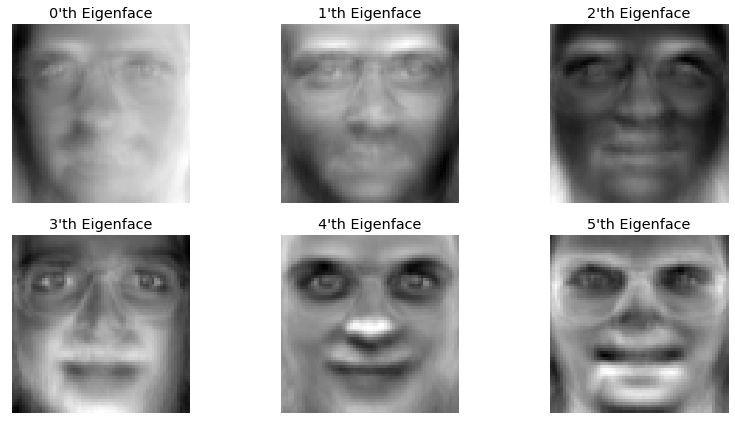

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, i in zip(axs.flatten(), range(6)):
    eigenface = faces_pcd.components_[i, :].reshape(image_shape)
    ax.imshow(eigenface, cmap=cm.gray)
    ax.set_title("{}'th Eigenface".format(i))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

### FIXME: Discussion prompt needs solution

**Question:** What facial features seem to be captured in the first few eigenfaces?  Why do you think this may be so?

__________
Notes (markdown):

In [47]:
# Scratch area (code)

### FIXME: Need more explanation. Why are we doing this exercise?

Let's do our reconstruction procedure with the face data.  This lets us create **smaller dimensional faces**.

In [48]:
def reduce_face_data(n_dim):
    eigenvalues = faces_pcd.components_[:n_dim, :].T
    faces_reduced = faces_centered @ eigenvalues @ eigenvalues.T
    return faces_reduced

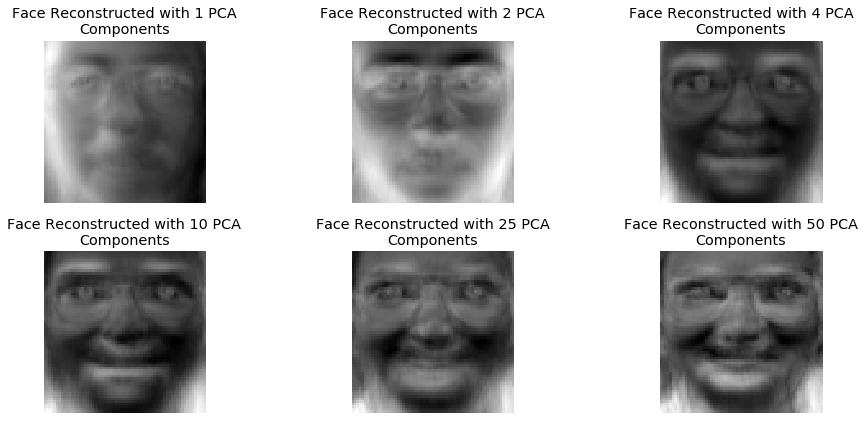

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))

for ax, dim in zip(axs.flatten(), [1, 2, 4, 10, 25, 50]):
    reduced_data = reduce_face_data(dim)
    first_face = reduced_data[0].reshape(image_shape)
    ax.imshow(first_face, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} PCA\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

### FIXME: Discussion prompt needs solution

**Discussion:** When applying PCA to reduce the dimensionality of a data set, we have to choose a *number of dimensions* to keep.  What kind of concerns should we consider when choosing this number?

__________
Notes (markdown):

In [50]:
# Scratch area (code)

### What Principal Componenets Analysis is NOT for

There is an, unfortunately, popular method which combines PCA with regression, with the intent of improving the generalization properties of the regression.  It is called **Principal Component Regression** and it goes like this:

### FIXME: It is not clear to me what this means

**Setup**: You have a matrix $X$ and a response $y$, and you want to fit a regression to predict $y$ from $X$.

**Procedure**:
1. Do PCA on $X$, let $E$ be the matrix of principal components.
2. Discard some of the principal components, get the matrix $E_{1:k}$.
3. Regress $y$ on $E_{1:k}$.

### FIXME: Discussion prompts need solutions

**Discussion:** Critique this procedure, pros and cons.

### FIXME: Never defined PCR

For details on why **not** to use selection of principal components as a regularization strategy in regression [see this paper](http://www.uvm.edu/~rsingle/stat380/F04/possible/Hadi%2BLing-AmStat-1998_PCRegression.pdf) and [this paper](http://automatica.dei.unipd.it/public/Schenato/PSC/2010_2011/gruppo4-Building_termo_identification/IdentificazioneTermodinamica20072008/Biblio/Articoli/PCR%20vecchio%2082.pdf).

[This question](http://stats.stackexchange.com/questions/101485/examples-of-pca-where-pcs-with-low-variance-are-useful) gives real life examples of data sets where PCR fails because $y$ is only related to the **low variance** principal components.

The moral of this story: PCA is reasonable as a variable creation strategy only when you have a good reason to believe that there are low variance components in $X$ that will *not* contribute to prediction.

Depending on the context, the above assumption could be reasonable or unreasonable, meaning careful consideration of the problem space is needed to determine if PCA should be used to select features.

**Discussion:** Why is PCA **not** a variable selection algorithm? What circumstances would allow variable selection by PCA to be a reasonable approach?

__________
Notes (markdown):

In [51]:
# Scratch area (code)

# Week 4 part 2 -- Clustering: k-means, hierarchical, and more!
In part one of this week, we looked at reasons why we would want to reduce the dimensionality of a dataset and the implications of doing so using **PCA**. In part 2, we will look at **Clustering**, another common unsupervised learning method that often comes next.

### By the end of part 2 of today's class, you should be able to:

* Implement a **k-means** algorithm for clustering
* Discuss how **curse of dimensionality** affects clustering
* Choose the best k using the **elbow method** or **silhouette scores**
* Implement and interpret **hierarchical clustering**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib
from IPython.display import HTML, display

### FIXME: Use definition of clustering from concepts course, link to concepts
### FIXME: Text very sparse, provide more context (info on the various algs, what within cluster sum of squares is, etc)
### FIXME: Questions need answers

## Clustering Problem

The goal of clustering is to divide the data into **distinct subgroups** such that observations within each group are similar.

![](../img/clusters.png)


## Various Algorithms

There are several approaches to clustering, each with variations.

* k-means clustering
* Hierarchical clustering
* Density-based clustering (DBSCAN)
* Distribution-based clustering
* ...

How do we measure how good the clustering is?

## Within-Cluster Sum of Squares

Measures the goodness of a clustering

$$W(C) = \sum_{k=1}^{K} \frac{1}{K} \sum_{C(i)=k}  \sum_{C(j)=k} || x_i - x_j ||^2 $$

where $K$ is the number of clusters, $C(i)$ is the cluster label of point $i$, and $x_i$ is the position of point $i$.

Do you need to normalize/standardize the data?

# k-means Algorithm

The k-means algorithm involves repeatedly assigning points to clusters and then finding new clusters based on those points.

* Choose a number of clusters k
* 1\. Choose initial clusters
* 2\. Repeatedly:
    * a\. For each of k clusters, compute cluster *centroid* by taking
mean vector of points in the cluster
    * b\. Assign each data point to cluster for which centroid is closest
(Euclidean)

...until clusters stop changing

This approach can be seen as simple version of an **Expectation-Maximization** algorithm. The step of choosing a new centroid is called a *maximization* step, finding the best cluster center given some data. The assignment of data points is the *expectation* step, finding the expected cluster for each point.

Discussion: how should we choose initial clusters? Does it matter?

# k-means Algorithm

![The k-means algorithm.](../img/kmeans.png)

__________
Notes (markdown):

In [53]:
# Scratch area (code)

# k-means++

Consider the points below. How would you break them into two clusters?

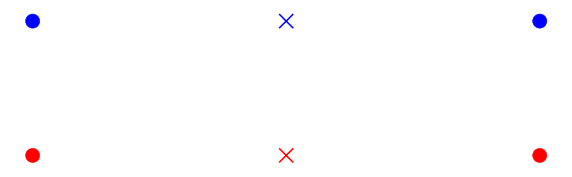

In [54]:
fig, ax = plt.subplots(figsize=(10,3))
colors = 'k'
ax.scatter([1, 1], [0, 1], marker='x', s=200, c=['r', 'b'])
colors = ['r', 'b', 'r', 'b']
ax.scatter([0, 0, 2, 2], [0, 1, 0, 1], s=200, c=colors)
ax.axis('off')
plt.show()

There are a couple common way to choose initial clusters. One is to choose randomly cluster centers from the initial points. Another is to randomly assign points to clusters and then find the centers of those.

Like many algorithms, it's easy to get caught in a local minimum. The usual way to avoid this is run the algorithm a number of times and find the best solution. `sklearn` does this automatically with the `n_init` parameter.

That helps, but can we choose better starting points?

k-means++ is the same algorithm as k-means but with a different initialization, attempting to find initial points near the center of different clusters.

 * Choose one point for first center.
 * Repeat:
    
    * Calculate distance from each point to the nearest center $d_i$
    * Choose a point to be the next center, randomly, using a weighed probability $d_i^2$

 ... until k centers have been chosen.

__________
Notes (markdown):

In [55]:
# Scratch area (code)

### FIXME: this section needs more guidance for the reader. What should they be focusing on in the code?
### FIXME: Need solution to discussion prompts

## What's the correct number of clusters?

We've talked about the "best" way to divide data into a given number of clusters, but what number is best?

In [56]:
clusters = [(-2, -3, .75, 100),
            (-5, -5, .75, 75),
            (4, 3, 1.5, 200),
            (1, -3, .5, 150),
            (-1, 0.15, 0.75, 100)]
k = len(clusters)
n = sum([c[3] for c in clusters])

x1 = np.array([])
x2 = np.array([])

for c in clusters:
    x1 = np.concatenate([x1, (stats.norm(c[0], c[2]).rvs(c[3]))])
    x2 = np.concatenate([x2, (stats.norm(c[1], c[2]).rvs(c[3]))])
x = np.stack((x1, x2)).T

(-9, 8)

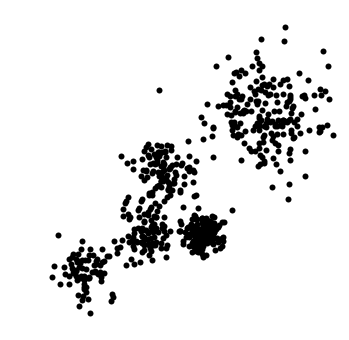

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
ax.axis('equal')
ax.scatter(x[:,0], x[:,1], linewidths=0, color='k')
ax.set_xlim(xmin=-9, xmax=8)


How many clusters do you see?

Let's try fitting them with k-means.

In [58]:
km = KMeans(5)
y = km.fit_predict(x)

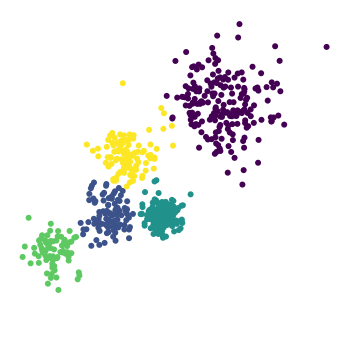

In [59]:
fig, ax = plt.subplots(figsize=(6,6))

ax.axis('off')
ax.axis('equal')
ax.scatter(x[:,0], x[:,1], c=y, linewidths=0)
ax.set_ylim(ymin=-9, ymax=8)
plt.show()

### FIXME: What data did we create these clusters from? This was not clear to me
### FIXME: Need solutions to discussion prompts
### FIXME: I would reorder this section. Showing the different k=n plots before discussing measures for best k.

These are basically the clusters we created the data from.

# Choosing K

Can we just use within-cluster sum of squares (WCSS) to choose k?


More clusters $\implies$ lower WCSS.

There are several measures for the "best" k, and no easy answer

 * The Elbow Method
 * Silhouette Score
 * GAP Statistic

First, let's cluster the data above with k-means with various values of $k$.

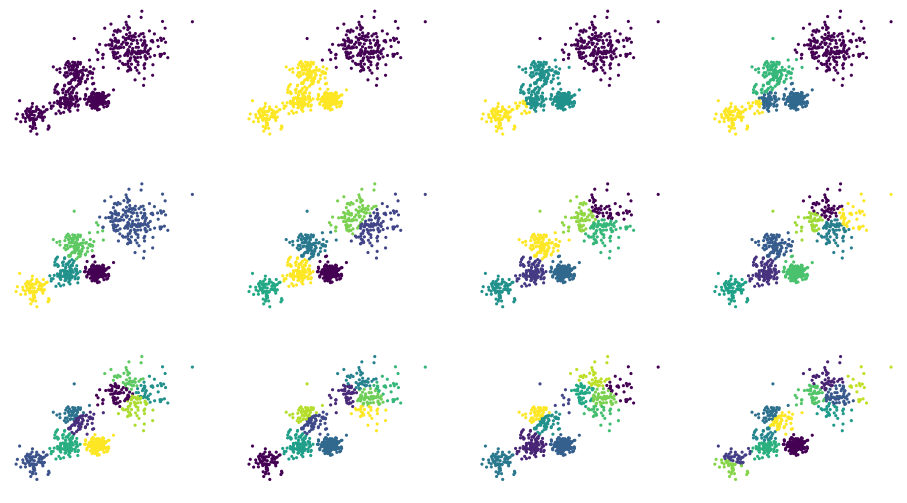

In [60]:
maxk = 13
wcss = np.zeros(maxk)
silhouette = np.zeros(maxk)

fig, axes = plt.subplots(3, 4, figsize=(16,9))

# flatten
axes = [ax for axrow in axes for ax in axrow]

for k, ax in zip(range(1,maxk), axes):
    km = KMeans(k)
    y = km.fit_predict(x)
    ax.axis('off')
    ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    ax.set_ylim(ymin=-9, ymax=8)
    
    
    for c in range(0, k):
        for i1, i2 in itertools.combinations([ i for i in range(len(y)) if y[i] == c ], 2):
            wcss[k] += sum(x[i1] - x[i2])**2
    wcss[k] /= 2
    
    if k > 1:
        silhouette[k] = silhouette_score(x,y)
    

### FIXME: question "What looks best" is vague

## The Elbow Method

Let's start with the Elbow method. In this, we simply plot the within-cluster sum of squares and try to see what looks like an elbow.

What looks best?

Text(0, 0.5, 'within-cluster sum of squares')

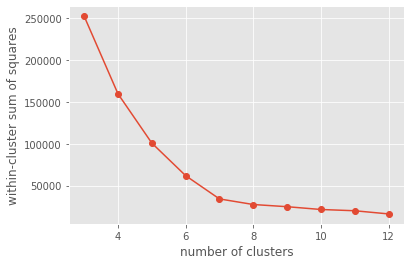

In [61]:
fig, ax = plt.subplots()
ax.plot(range(3,maxk), wcss[3:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("within-cluster sum of squares")

__________
Notes (markdown):

In [62]:
# Scratch area (code)

### FIXME: Needs more context, answer to discussion question

What we want is some metric we can maximize.

What would that look like?

### FIXME: Link out to more info?
### FIXME: DIscussion prompts need solutions

# Choosing K -- Silhouette Score

For each point $x_i$:

 * $a(i)$ average dissimilarity of $x_i$ with points in the same cluster
 * $b(i)$ average dissimilarity of $x_i$ with points in the nearest cluster
    * "nearest" means cluster with the smallest $b(i)$

$$\text{silhouette}(i) = \frac{b(i) - a(i)}{max(a(i), b(i))} $$

What's the range of silhouette scores?

The silhouette score of a clustering is the average of silhouette score of all points.

Text(0, 0.5, 'silhouette score')

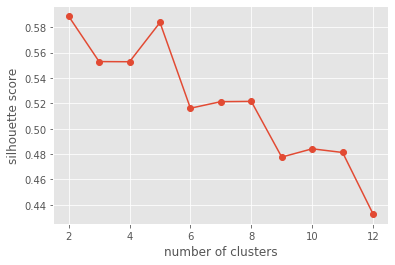

In [63]:
fig, ax = plt.subplots()
ax.plot(range(2,maxk), silhouette[2:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")
#ax.set_ylim(ymin=0.0, ymax=1.0)

### FIXME: Clearly define what "oops" means

Possible silhouette scores:
 * near 1: very small tight cluster.
 * 0: at the edge of two clusters; could be in either.
 * < 0: oops.

The higher the the average silhouette score, the tighter and more separated the clusters.

# Silhouette Graph

A silhouette graph is a representation of the silhouette score of every data point, grouped first by cluster and then in decreasing value.

### FIXME: Really dense code below
### FIXME: Need more discussion on how to interpret the plots below
### FIXME: The red line is the avg silhouette score: make this clearer; why do we use the Avg? Is this standard?

For n_clusters = 2 The average silhouette_score is : 0.588659921382804


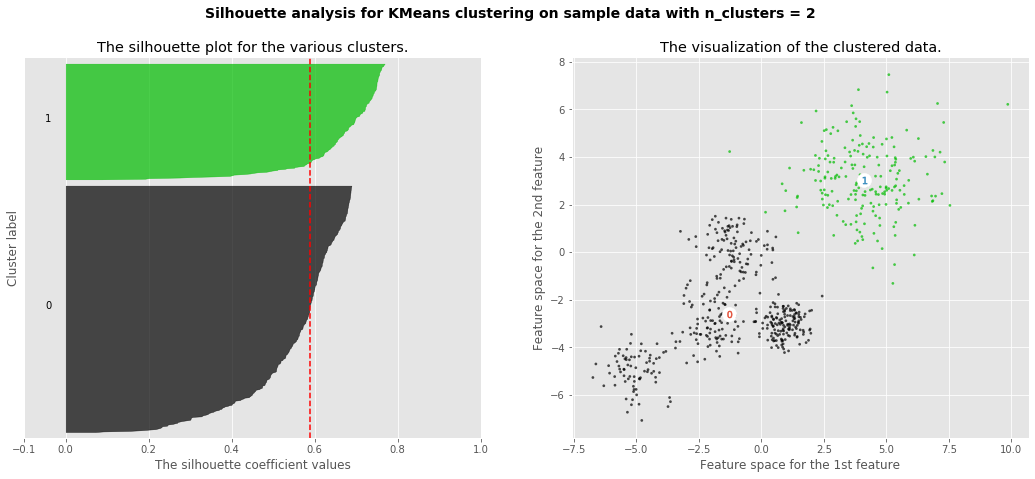

For n_clusters = 3 The average silhouette_score is : 0.5529076329245767


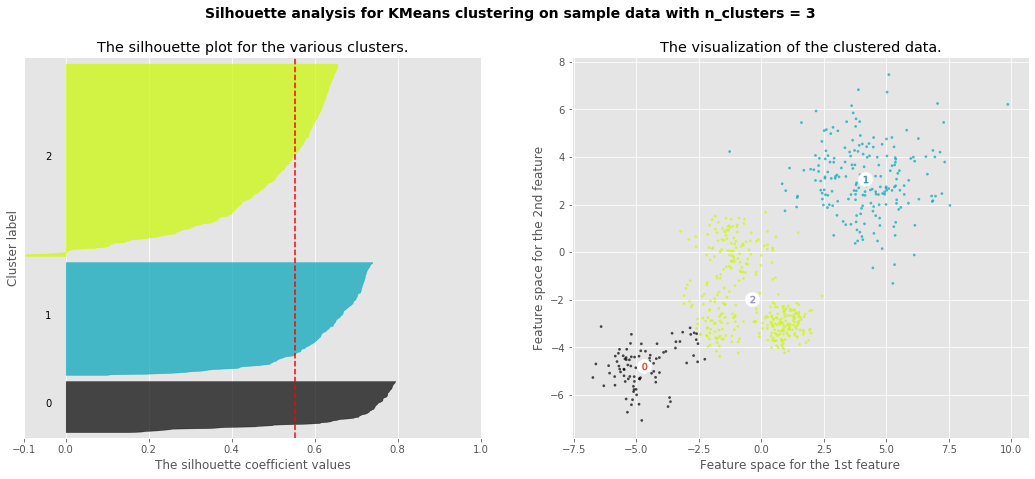

For n_clusters = 4 The average silhouette_score is : 0.5527811881495676


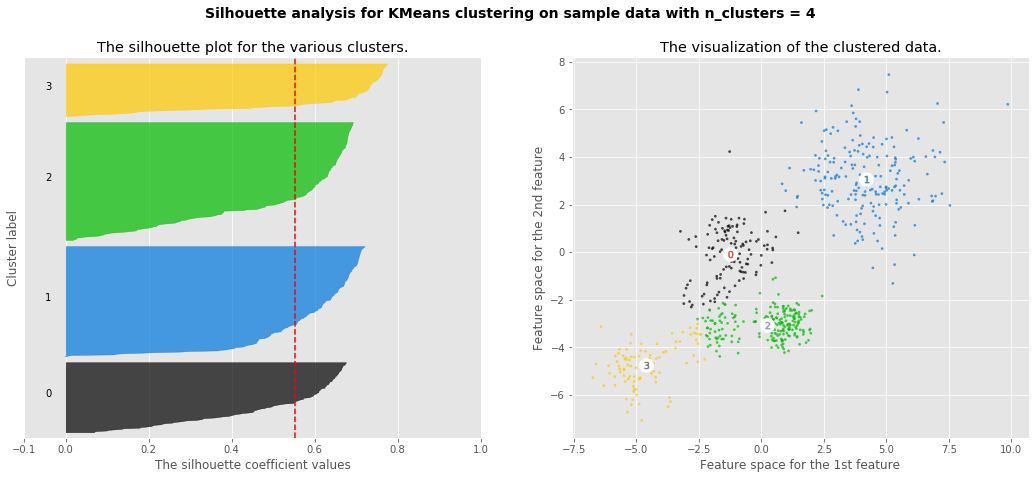

For n_clusters = 5 The average silhouette_score is : 0.5837281314781129


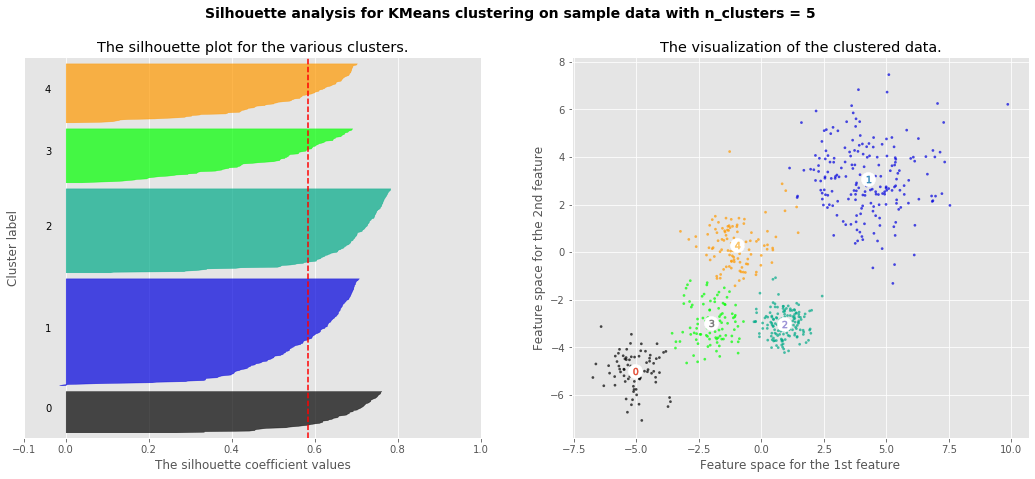

For n_clusters = 6 The average silhouette_score is : 0.516715992668713


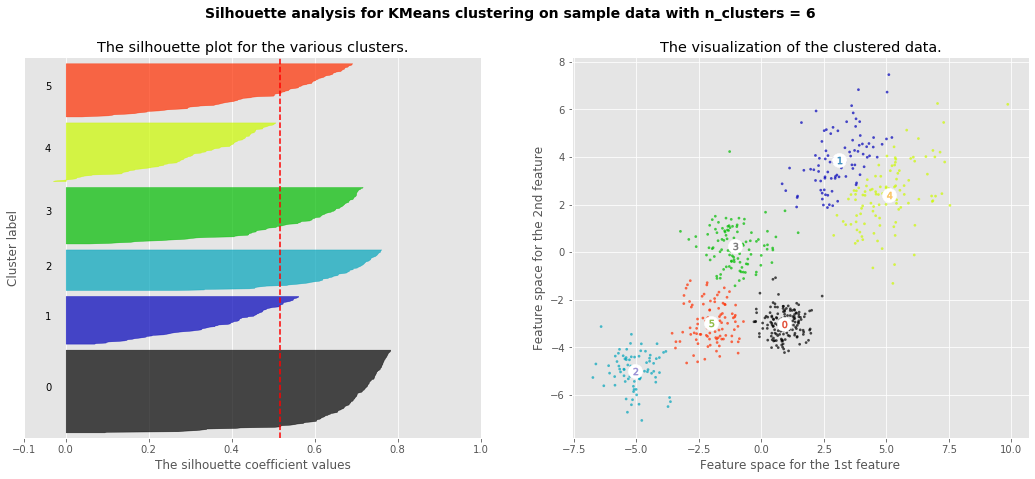

For n_clusters = 7 The average silhouette_score is : 0.5203531717075435


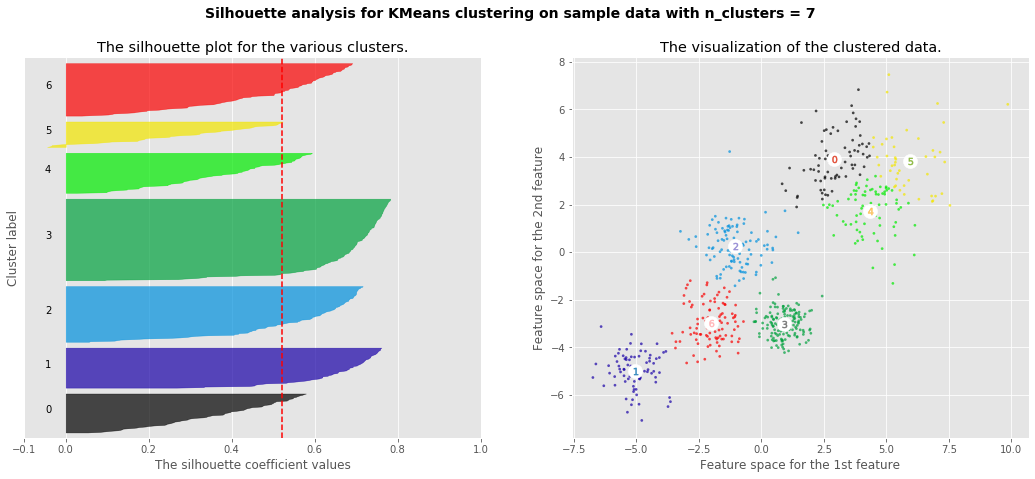

For n_clusters = 8 The average silhouette_score is : 0.5215348058337486


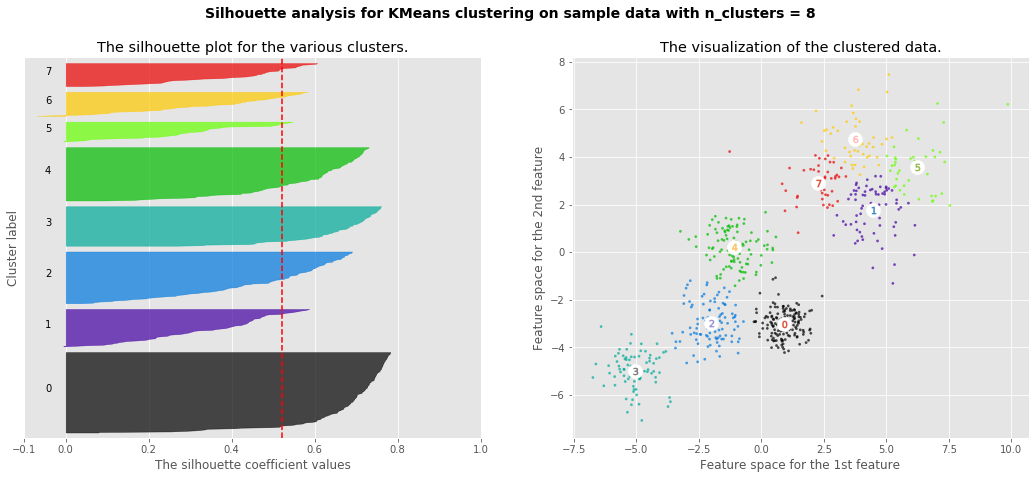

For n_clusters = 9 The average silhouette_score is : 0.4805364835805577


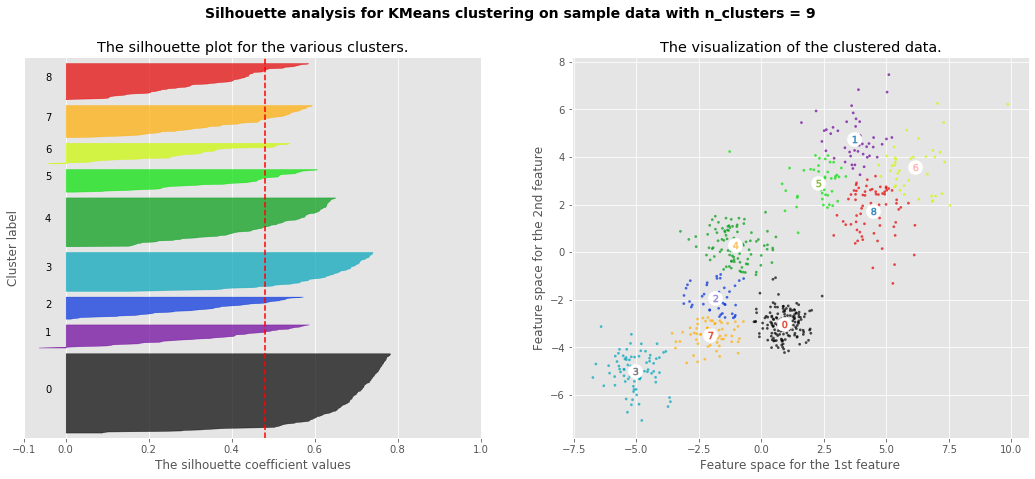

In [64]:
X = x
range_n_clusters = range(2,10)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

__________
Notes (markdown):

In [65]:
# Scratch area (code)

### FIXME: Needs more context, link out

# For Later Consideration: Choosing K -- GAP Statistic

For each $K$, compare $W_K$ (within-cluster sum of squares) with that of randomly generated "reference distributions"

Generate B distributions

$$Gap(K) = \frac{1}{B} \sum_{b=1}^B \log{W_{Kb}} - \log{W_K}$$

Choose smallest K such that $Gap(K) \ge Gap(K+1) - s_{N+1}$

where $s_{K}$ is the standard error of $Gap(K)$

# Hierarchical Clustering

With many clustering methods the goal is to divide the data into a specific number of clusters. With hierarchical clustering we group data points as leaves on a tree, clustering them into larger and larger groups.

How would we group these?

![](../img/letters-ungrouped.png)


<table><tr><td><img src='../img/letters-grouped.png'></td><td><img src='../img/letters-dendrogram.png'></td></tr></table>


# Hierarchical Clustering

The basic algorithm of hierarchical clustering is

 * Assign each point to its own cluster
 * Repeat:

   * Compute distances between clusters
   * Merge closest clusters

 ...until all are merged

How do we define dissimilarity between clusters?

## Linkage

It's easy to talk about the distance (or dissimilarity) between two points, but between clusters it's less clear. There are a few different measures used.

* **Complete:** Maximum pairwise dissimilarity between points in clusters -- good
* **Average:** Average of pairwise dissimilarity between points in clusters -- also good
* **Single:** Minimum pairwise dissimilarity between points in clusters -- not as good; can lead to long narrow clusters
* **Centroid:** Dissimilarity between centroids -- used in genomics; risk of inversions

__________
Notes (markdown):

In [66]:
# Scratch area (code)

### FIXME: I feel like this should be a part of the Kmeans section
### FIXME: "and other methods" but only addresses Kmeans

# Problems with k-means and other methods

k-means has limitations.

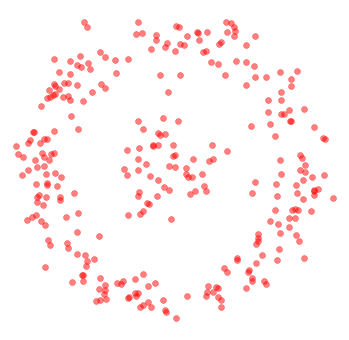

In [67]:
fig, ax = plt.subplots(figsize=(6,6))
r = np.concatenate([stats.norm(8,1).rvs(250),
                    stats.norm(2,1).rvs(50)])
a = stats.uniform(0, 6.28).rvs(300)
x = r * np.cos(a)
y = r * np.sin(a)

ax.axis('equal')
ax.axis('off')
ax.scatter(x, y, color="r", alpha=0.5)

### FIXME: need solution to discussion prompt

What will k-means do here?

__________
Notes (markdown):

In [68]:
# Scratch area (code)

### FIXME: Need context as to why this is important

# DBSCAN

With DBSCAN (Density-Based Spacial Clustering of Applications with Noise) we don't specify the number of clusters. Instead we specify:

 * $\epsilon$: distance between points for them to be connected
 * minPts: number of connected points for a point to be a "core" point

A cluster is all connected core points, plus others within $\epsilon$ of one of those. Other points are noise.

Let's tackle the above problem with DBSCAN.

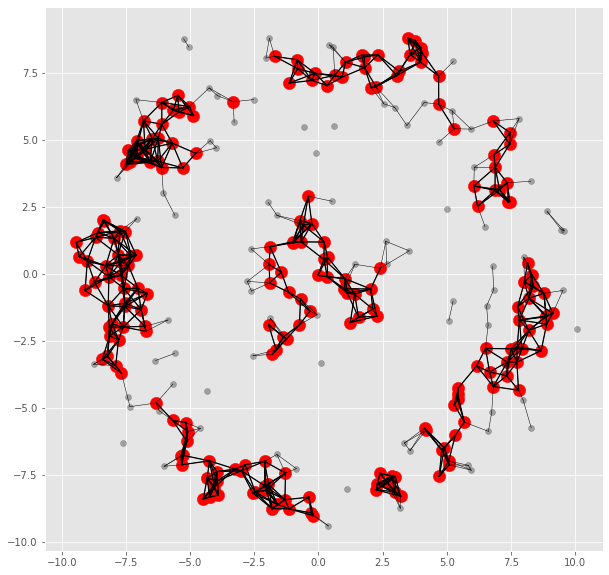

In [69]:
epsilon = 1.1
minpts = 4

fig, ax = plt.subplots(figsize=(10,10))

distances = squareform(pdist(np.stack([x,y], axis=1)))
connected = distances < epsilon
ax.scatter(x, y, color="k", alpha=0.3)
for i in range(len(x)):
    for j in range(i):
        if connected[i,j]:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'k', lw=0.5)

coreindices = np.where(connected.sum(axis=0) > (minpts))[0]
ax.scatter(x[coreindices], y[coreindices], s=150, c='r')

for i in coreindices:
    for j in coreindices:
        if i > j and connected[i,j]:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'k', lw=1.2)

There is even a hierarchical version of DBSCAN called HDBSCAN that yields excellent results by incorporating hierarchical aspects in the approach.

__________
Notes (markdown):

In [70]:
# Scratch area (code)

### FIXME: Make each step clearer. What is happening and why are we doing it?

# For Later Consideration: Distribution-based clustering

With distribution-based clustering we assume some fixed number of clusters, and assume they follow some (often normal) distribution. We then try to find the parameters that have the **maximum likelihood** of producing these data.

This is more difficult then other problems we've seen because we don't know which point came from which distribution. We need to add some hidden variables to the problem: the probability each point came from each distribution. We can solve this by an **expectation-maximization** (EM) algorithm in which we alternate between expectation steps (where we calculate the hidden variables) and maximization steps (in which we calculate the maximum-likelihood parameters assuming the hidden variables are correct).

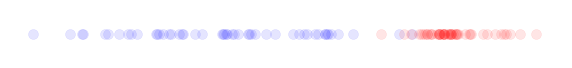

In [71]:
npts = 100
actual_mus = 1, 5
actual_sds = 1.5, 0.5
x = np.concatenate([stats.norm(actual_mus[0], actual_sds[0]).rvs(npts//2),
                    stats.norm(actual_mus[1] ,actual_sds[1]).rvs(npts//2)])
y = np.ones(npts)/2.
fig, ax = plt.subplots(figsize=(10,1))
ax.scatter(x[:npts//2], y[:npts//2], c='b', alpha=0.1, s=100)
ax.scatter(x[npts//2:], y[npts//2:], c='r', alpha=0.1, s=100)
ax.axis('off')
plt.show()

The first step is to make guesses for the two starting distrubitions. Let's go with N(0,1) and N(2,1).

In [72]:
mus = [-1, 0]
sds = [1, 1]
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]
actual_dists = [stats.norm(mu, sd) for mu, sd in zip(actual_mus, actual_sds)]

### FIXME: Need some info on how to make sense of these plots.

      actual  estimate
mu_0  1.00    -1.000
mu_1  5.00    0.000
sd_0  1.50    1.000
sd_1  0.50    1.000


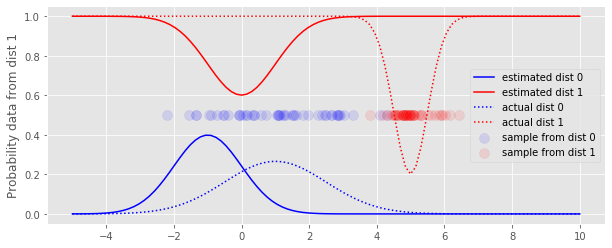

In [73]:
def plot_em(x, y, dists, actual_dists):
    xpts = np.linspace(-5,10,100)
    fig, ax = plt.subplots(figsize=(10,4))
    npts = len(x)
    ax.scatter(x[:npts//2], y[:npts//2], c='b', alpha=0.1, s=100, label="sample from dist 0")
    ax.scatter(x[npts//2:], y[npts//2:], c='r', alpha=0.1, s=100, label="sample from dist 1")
    ax.plot(xpts, dists[0].pdf(xpts), 'b', label="estimated dist 0")
    ax.plot(xpts, 1-dists[1].pdf(xpts), 'r',  label="estimated dist 1")
    ax.plot(xpts, actual_dists[0].pdf(xpts), 'b:',  label="actual dist 0")
    ax.plot(xpts, 1-actual_dists[1].pdf(xpts), 'r:',  label="actual dist 1")
    ax.set_ylabel("Probability data from dist 1")
    ax.legend()

def print_stats(actual_mus, actual_sds, mus, sds):
    #for i in (0, 1):
    print("      actual  estimate")
    print("mu_0  {0:.2f}    {1:.3f}".format(actual_mus[0], mus[0]))
    print("mu_1  {0:.2f}    {1:.3f}".format(actual_mus[1], mus[1]))
    print("sd_0  {0:.2f}    {1:.3f}".format(actual_sds[0], sds[0]))
    print("sd_1  {0:.2f}    {1:.3f}".format(actual_sds[1], sds[1]))

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

Now we're going to calculate the relative likelihood that each point will be in `dist[1]` (the upper distribution, as opposed to `dist[0]`, the lower one).

We'll plot that.

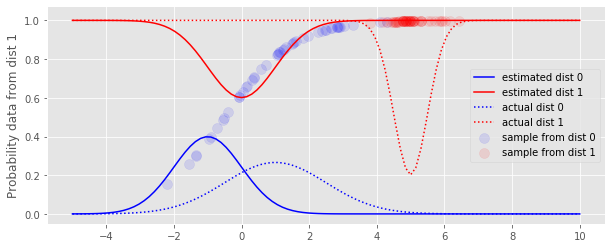

In [74]:
y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))

plot_em(x, y, dists, actual_dists)

Now we update each distribution to be (normal) distribution that has the maximum likelihood of generating the data. We'll weight each point by the probability (calculated above) of being in that distribution.

We can just use the (weighted) means and standard deviations for this.

      actual  estimate
mu_0  1.00    -0.119
mu_1  5.00    3.510
sd_0  1.50    0.763
sd_1  0.50    1.733


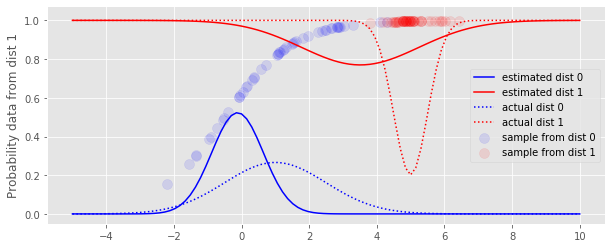

In [75]:
def weighted_stats(x, weights):
    wtotal = weights.sum()
    wmean = (x * weights).sum() / wtotal
    wsd = (((weights*(x - wmean))**2).sum() / wtotal)**0.5
    return wmean, wsd

mus[0], sds[0] = weighted_stats(x, 1-y)
mus[1], sds[1] = weighted_stats(x, y)
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

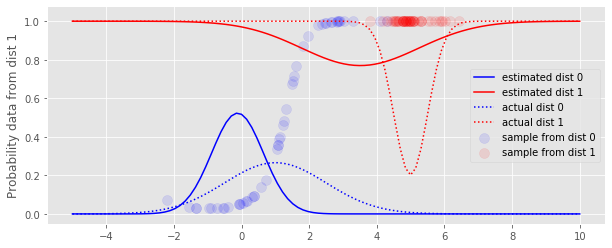

In [76]:
y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))
plot_em(x, y, dists, actual_dists)

      actual  estimate
mu_0  1.00    -0.010
mu_1  5.00    4.121
sd_0  1.50    0.835
sd_1  0.50    1.239


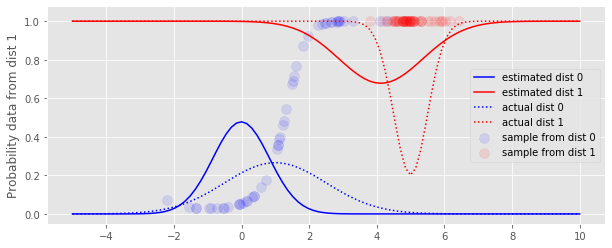

In [77]:
mus[0], sds[0] = weighted_stats(x, 1-y)
mus[1], sds[1] = weighted_stats(x, y)
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

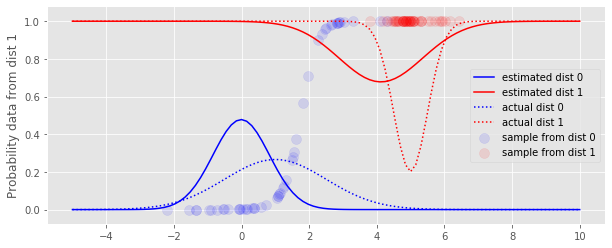

In [78]:
y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))
plot_em(x, y, dists, actual_dists)

      actual  estimate
mu_0  1.00    0.209
mu_1  5.00    4.392
sd_0  1.50    0.961
sd_1  0.50    1.056


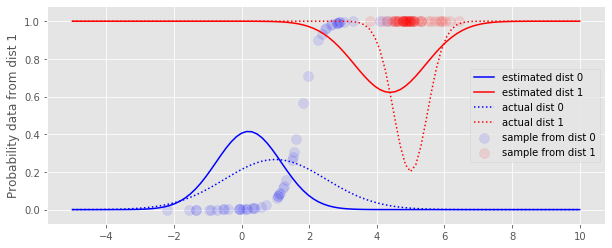

In [79]:
mus[0], sds[0] = weighted_stats(x, 1-y)
mus[1], sds[1] = weighted_stats(x, y)
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

In [80]:
for i in range(100):
    y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))
    mus[0], sds[0] = weighted_stats(x, 1-y)
    mus[1], sds[1] = weighted_stats(x, y)
    dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

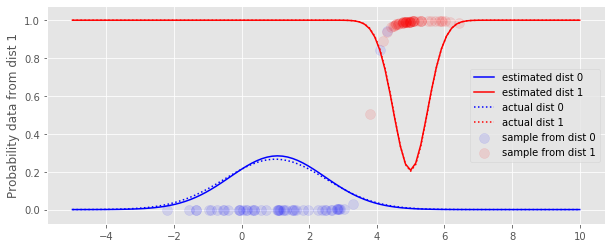

In [81]:
plot_em(x, y, dists, actual_dists)


__________
Notes (markdown):

In [82]:
# Scratch area (code)

# Week 4 part 3 -- PCA and Clustering in Action
In parts 1 and 2 of today's class, we looked at dimensionality reduction using PCA and subsequent clustering using common techniques. In the final part of today's class, we'll investigate how these methods could be used in some important problem spaces.

### By the end of part 3 of today's class, you should be able to:

 * Investigate a real world dataset using PCA.
 * Implement k-means and hierarchical clustering on a generated dataset and contast the results.
 * Run the entire suite on the NCI60 gene expression dataset included with R.

In [83]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

%matplotlib inline
plt.style.use('seaborn-white')

## Section A: Principal Component Analysis

### FIXME: add some info about the dataset? Move from comments to text
### FIXME: this whole section needs more context, info about what and why we are doing things
### FIXME: I think my personal preference would be to include this section under PCA and clustering respectively rather than split them out into their own sections

In [84]:
# This dataset is part of the base R distribution, exported here as a .csv file for convenience.
df = pd.read_csv('../data/USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [85]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [86]:
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

In [87]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [88]:
# The loading vectors
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=df.columns, columns=['V1', 'V2', 'V3', 'V4'])
pca_loadings

,V1,V2,V3,V4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


In [89]:
# Fit the PCA model and transform X to get the principal components
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
df_plot

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996
Colorado,1.514563,-0.987555,1.095007,0.001465
Connecticut,-1.358647,-1.088928,-0.643258,-0.118469
Delaware,0.047709,-0.325359,-0.718633,-0.881978
Florida,3.013042,0.039229,-0.576829,-0.096285
Georgia,1.639283,1.278942,-0.342460,1.076797


### FIXME: What are we supposed to learn from this plot?

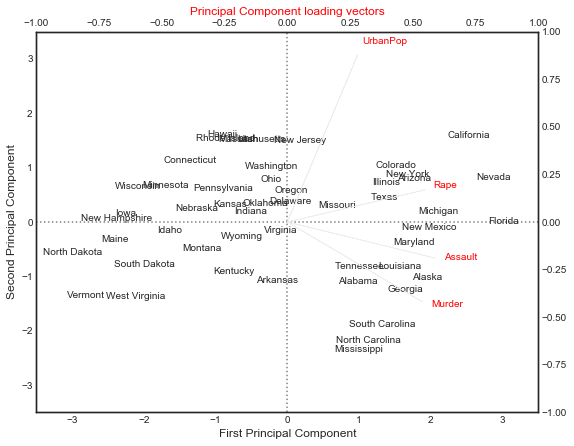

In [90]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='red')
ax2.set_xlabel('Principal Component loading vectors', color='red')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='red')

# Plot vectors
ax2.arrow(0,0,pca_loadings.V1[0], -pca_loadings.V2[0])
ax2.arrow(0,0,pca_loadings.V1[1], -pca_loadings.V2[1])
ax2.arrow(0,0,pca_loadings.V1[2], -pca_loadings.V2[2])
ax2.arrow(0,0,pca_loadings.V1[3], -pca_loadings.V2[3]);

__________
Notes (markdown):

In [91]:
# Scratch area (code)

In [92]:
# Standard deviation of the four principal components
np.sqrt(pca.explained_variance_)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

In [93]:
pca.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [94]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

### FIXME: Before this section there is no description of what PCA explained variance is and why we are plotting it

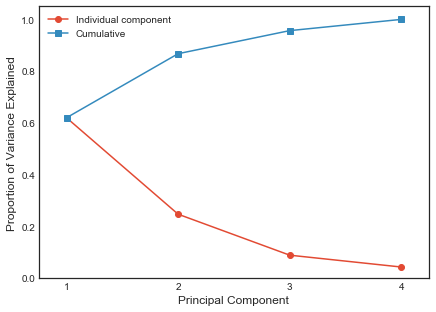

In [95]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2);

__________
Notes (markdown):

In [96]:
# Scratch area (code)

## Section B: Clustering

### FIXME: A lot of code without any sort of explanation why

### B1: K-Means Clustering

In [97]:
# Generate data
np.random.seed(2)
X = np.random.standard_normal((50,2))
X[:25,0] = X[:25,0]+3
X[:25,1] = X[:25,1]-4

#### K = 2

In [98]:
km1 = KMeans(n_clusters=2, n_init=20)
km1.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [99]:
km1.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1], dtype=int32)

See plot for K=2 below.

####  K = 3

In [100]:
np.random.seed(4)
km2 = KMeans(n_clusters=3, n_init=20)
km2.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [101]:
pd.Series(km2.labels_).value_counts()

2    21
1    20
0     9
dtype: int64

In [102]:
km2.cluster_centers_

array([[ 0.69945422, -2.14934345],
       [-0.27876523,  0.51224152],
       [ 2.82805911, -4.11351797]])

In [103]:
km2.labels_

array([2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0,
       2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0], dtype=int32)

In [104]:
# Sum of distances of samples to their closest cluster center.
km2.inertia_

68.97379200939726

### What are we supposed to take away from this exercise in plotting?

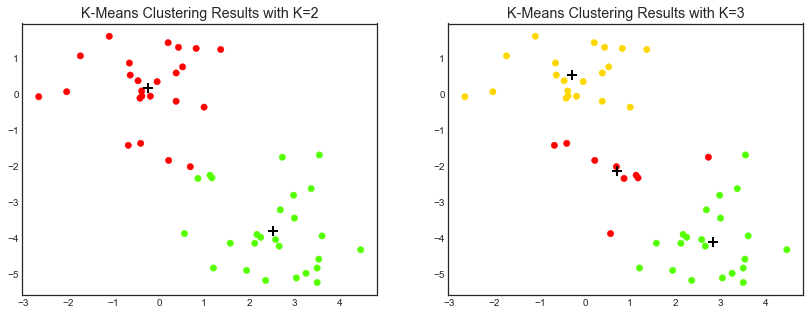

In [105]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.scatter(X[:,0], X[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

ax2.scatter(X[:,0], X[:,1], s=40, c=km2.labels_, cmap=plt.cm.prism) 
ax2.set_title('K-Means Clustering Results with K=3')
ax2.scatter(km2.cluster_centers_[:,0], km2.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2);

__________
Notes (markdown):

In [106]:
# Scratch area (code)

### B2: Hierarchical Clustering

### FIXME: Needs more context, again - spell out what the takeaway from these plots should be

#### scipy

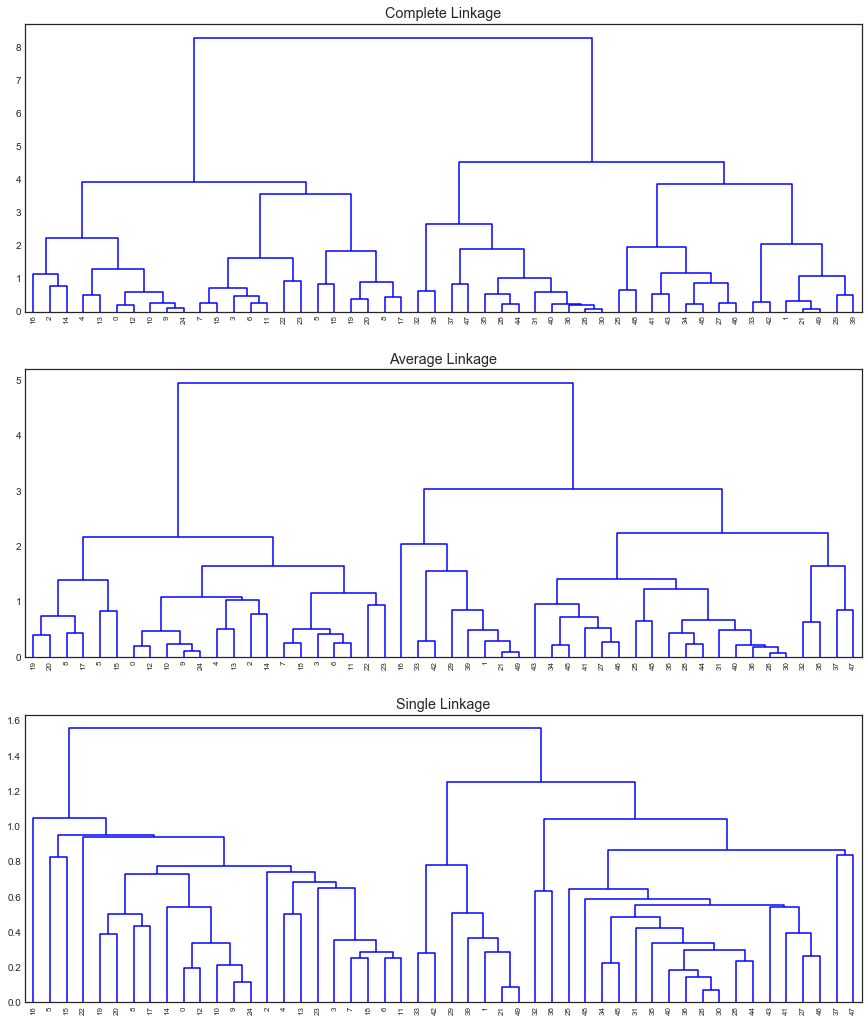

In [107]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,18))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)], ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, ax=ax, color_threshold=0)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

__________
Notes (markdown):

In [108]:
# Scratch area (code)

## Section C: NCI60 Data Example

### FIXME: Provide info on this dataset here

### NCI60 PCA

In [109]:
# The two elements of this ISLR dataset are presented as csv files.
# There is one file for the features and another file for the classes/types.
df2 = pd.read_csv('../data/NCI60_X.csv').drop('Unnamed: 0', axis=1)
df2.columns = np.arange(df2.columns.size)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Columns: 6830 entries, 0 to 6829
dtypes: float64(6830)
memory usage: 3.3 MB


In [110]:
X = pd.DataFrame(scale(df2))
X.shape

(64, 6830)

In [111]:
y = pd.read_csv('../data/NCI60_y.csv', usecols=[1], skiprows=1, names=['type'])
y.shape

(64, 1)

In [112]:
y.type.value_counts()

NSCLC          9
RENAL          9
MELANOMA       8
COLON          7
BREAST         7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
K562A-repro    1
K562B-repro    1
MCF7A-repro    1
UNKNOWN        1
MCF7D-repro    1
Name: type, dtype: int64

In [113]:
# Fit the PCA model and transform X to get the principal components
pca2 = PCA()
df2_plot = pd.DataFrame(pca2.fit_transform(X))

### FIXME: Need clear info on what the takeaways of the following plots should be

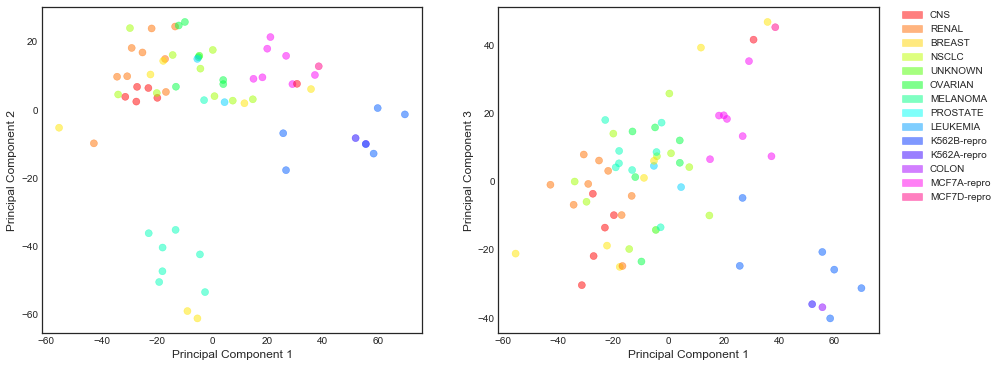

In [114]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

color_idx = pd.factorize(y.type)[0]
cmap = plt.cm.hsv

# Left plot
ax1.scatter(df2_plot.iloc[:,0], -df2_plot.iloc[:,1], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax1.set_ylabel('Principal Component 2')

# Right plot
ax2.scatter(df2_plot.iloc[:,0], df2_plot.iloc[:,2], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax2.set_ylabel('Principal Component 3')

# Custom legend for the classes (y) since we do not create scatter plots per class (which could have their own labels).
handles = []
labels = pd.factorize(y.type.unique())
norm = mpl.colors.Normalize(vmin=0.0, vmax=14.0)

for i, v in zip(labels[0], labels[1]):
    handles.append(mpl.patches.Patch(color=cmap(norm(i)), label=v, alpha=0.5))

ax2.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# xlabel for both plots
for ax in fig.axes:
    ax.set_xlabel('Principal Component 1')    

__________
Notes (markdown):

In [115]:
# Scratch area (code)

In [116]:
pd.DataFrame([df2_plot.iloc[:,:5].std(axis=0, ddof=0).values,
              pca2.explained_variance_ratio_[:5],
              np.cumsum(pca2.explained_variance_ratio_[:5])],
             index=['Standard Deviation', 'Proportion of Variance', 'Cumulative Proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

,PC1,PC2,PC3,PC4,PC5
Standard Deviation,27.853469,21.481355,19.820465,17.032556,15.971807
Proportion of Variance,0.113589,0.067562,0.057518,0.042476,0.037350
Cumulative Proportion,0.113589,0.181151,0.238670,0.281145,0.318495


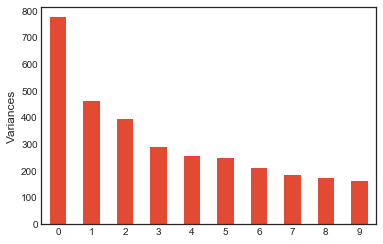

In [117]:
df2_plot.iloc[:,:10].var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances');

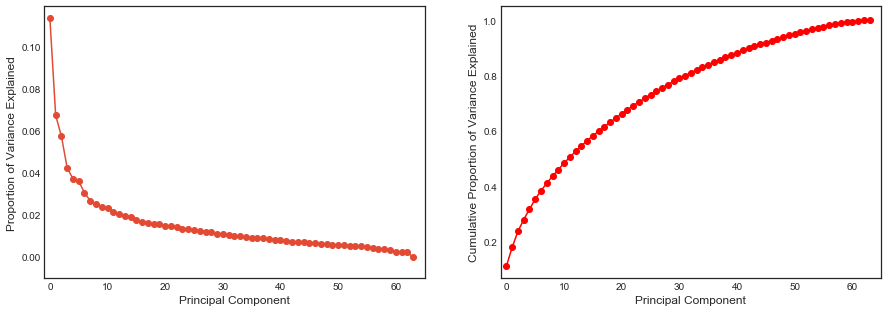

In [118]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Left plot
ax1.plot(pca2.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

# Right plot
ax2.plot(np.cumsum(pca2.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,65)    

__________
Notes (markdown):

In [119]:
# Scratch area (code)

### NCI60 Clustering

In [120]:
X= pd.DataFrame(scale(df2), index=y.type, columns=df2.columns)

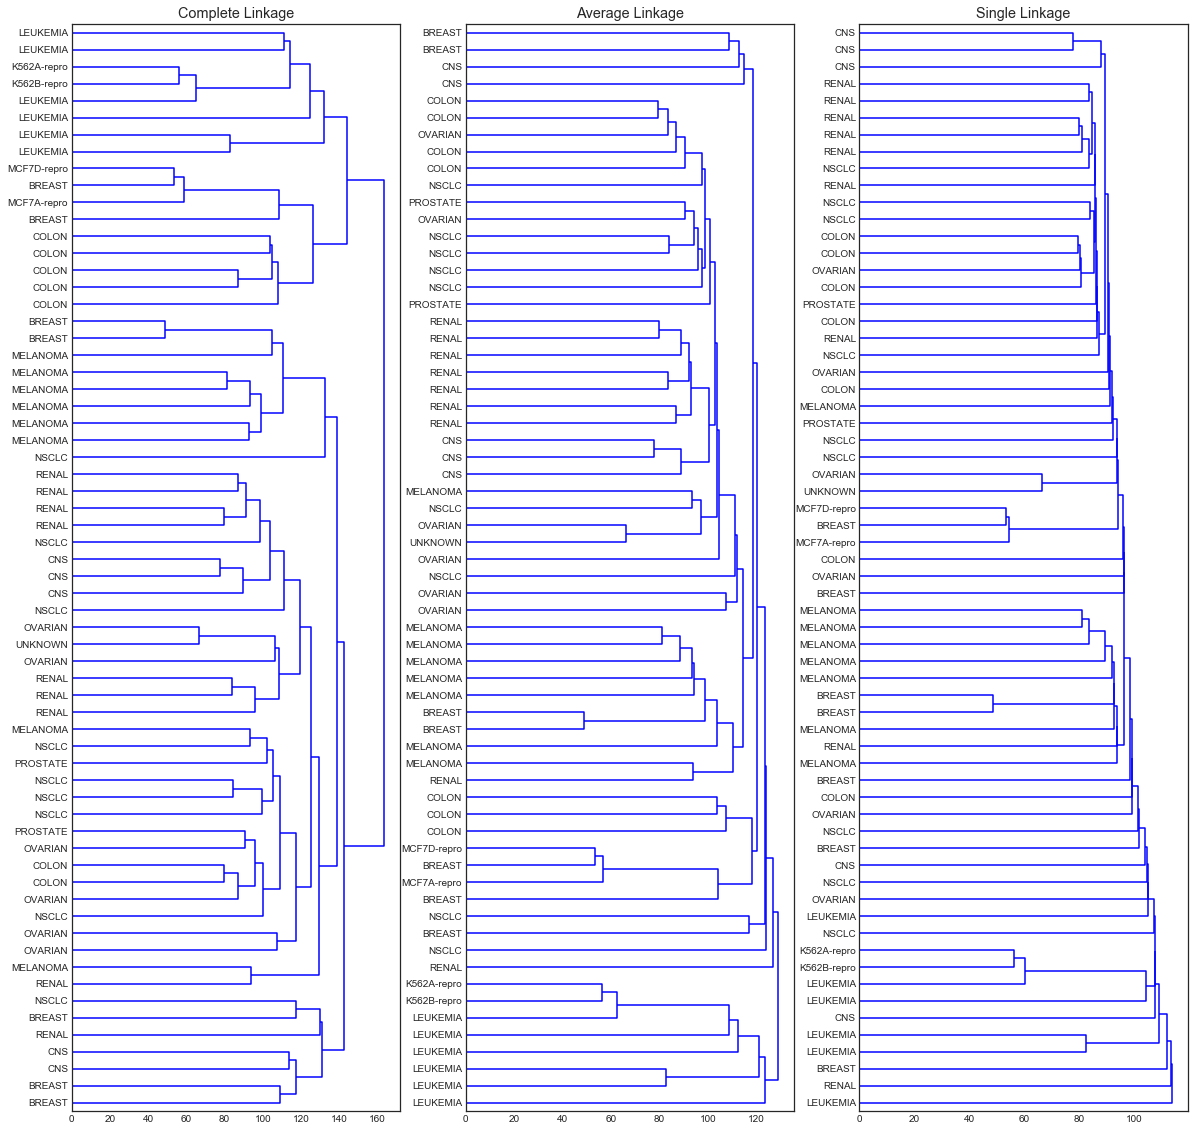

In [121]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, labels=X.index, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

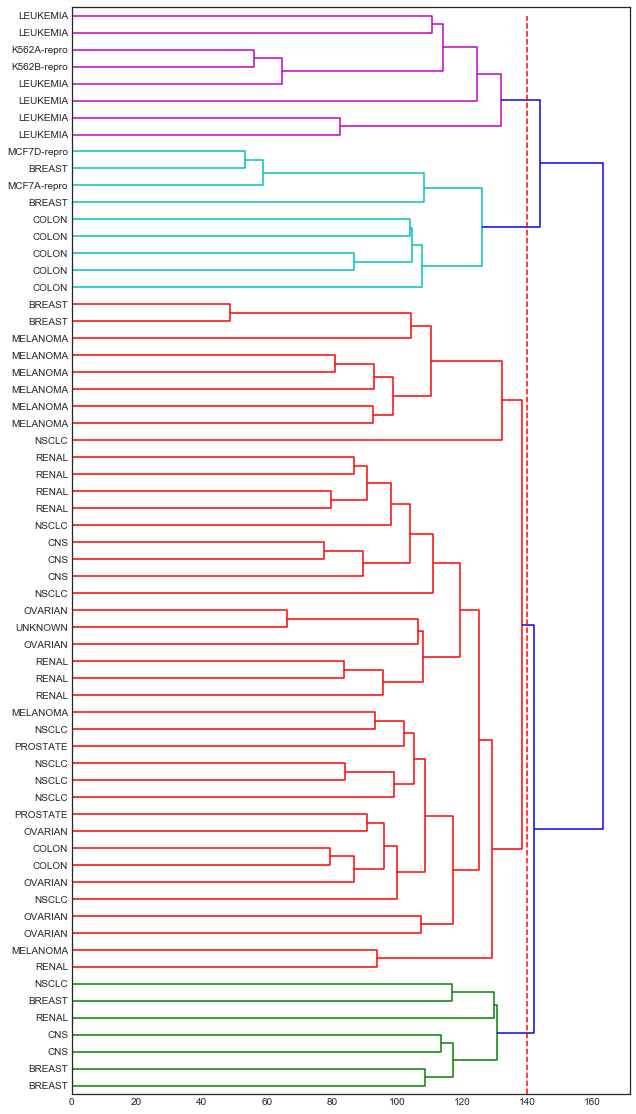

In [122]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hierarchy.complete(X),
                            labels=X.index, orientation='right', color_threshold=140, leaf_font_size=10)
plt.vlines(140,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed');

__________
Notes (markdown):

In [123]:
# Scratch area (code)

### FIXME: Random kmeans section within heirarchical clustering section

##### KMeans

In [124]:
np.random.seed(2)
km4 = KMeans(n_clusters=4, n_init=50)
km4.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [125]:
km4.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [126]:
# Observations per KMeans cluster
pd.Series(km4.labels_).value_counts().sort_index()

0    11
1     9
2     9
3    35
dtype: int64

__________
Notes (markdown):

In [127]:
# Scratch area (code)

##### Hierarchical

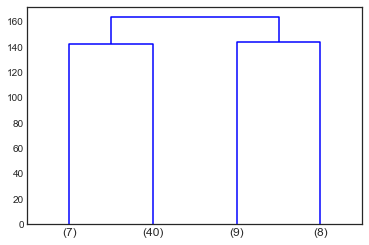

In [128]:
# Observations per Hierarchical cluster
cut4b = hierarchy.dendrogram(hierarchy.complete(X), truncate_mode='lastp', p=4, show_leaf_counts=True)

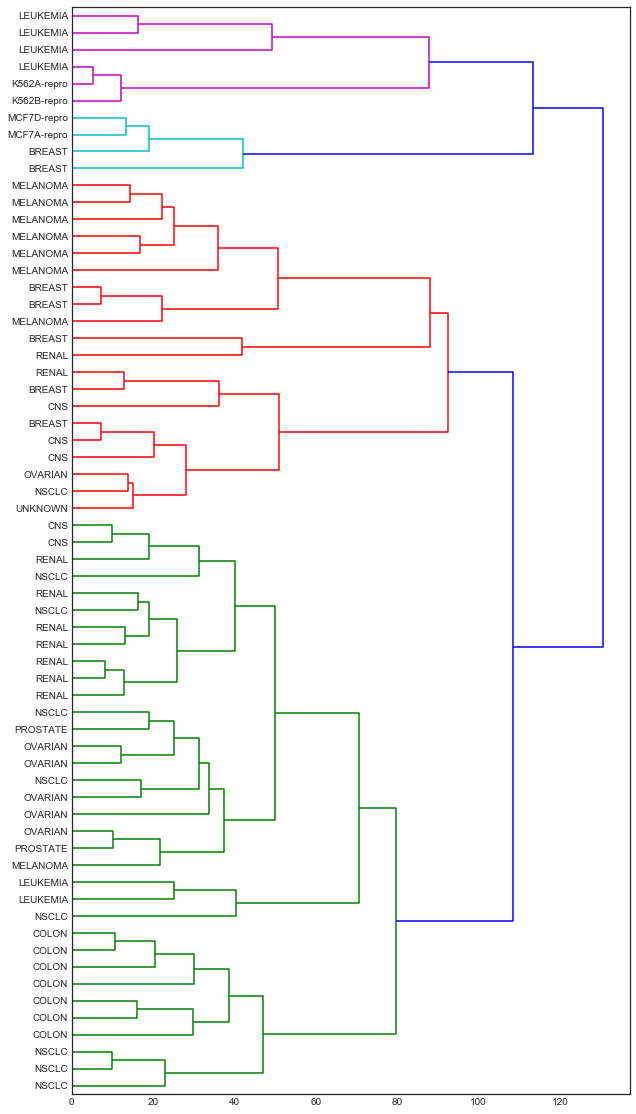

In [129]:
# Hierarchy based on Principal Components 1 to 5
plt.figure(figsize=(10,20))
pca_cluster = hierarchy.dendrogram(hierarchy.complete(df2_plot.iloc[:,:5]), labels=y.type.values, orientation='right', color_threshold=100, leaf_font_size=10)

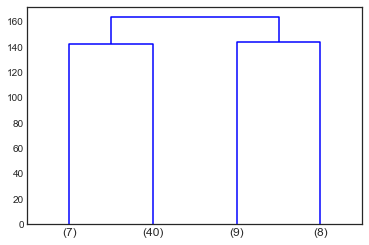

In [130]:
cut4c = hierarchy.dendrogram(hierarchy.complete(df2_plot), truncate_mode='lastp', p=4,
                             show_leaf_counts=True)
# See also color coding in plot above.

__________
Notes (markdown):

In [131]:
# Scratch area (code)

### FIXME: The above section has a lot of good plots/info but it's not clear

### FIXME: I believe that we have discussed curse of dimensionality before - need to double check.

# Additional Exploration: The Curse of Dimensionality

The Curse of Dimensionality is a way of saying that in high-dimensional space, things behave in unexpected ways. In particular, models based largely on finding the closest distances behave poorly.

Random variation in extra dimensions can hide significant differences between clusters. This can become a serious problem with a large number of dimensions, as no point is really close to any other point and distances alone because less meaningful.

In [132]:
# function to plot histograms on top of each other cleanly
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs


def multihist(x, y, bins=None, binsize=None, xmin=None, xmax=None, ymax=None,
              normed=1, kde=False, alpha=0.3, figsize=(12, 8), title=None):
    '''
    Plot a set of overlapping histograms with identical bins
    INPUT:
    x:      numpy array; data points to plot
    y:      numpy array of the same length;
            will plot histogram for each unique value of y
    bins:   int; number of bins in histogram
    binsize:float: size of bins (overrides bins)
    xmin:   lower limit (or None to set to min of data)
    xmax:   upper limit (or None to set to max of data)
    ymax:   upper limit of y
    normed: normalize w each histograph; pass to matplotlib
    kde:    add kde plot
    alpha:  float; opacity; pass to matplotlib
    figsize:tuple; width and height of figure; pass to matplotlib
    title:  str; title of plot
    '''

    fig, ax = plt.subplots(figsize=figsize)

    if not title is None:
        ax.set_title(title)

    # handle specifying xmin/xmax by clipping values to that range
    if (xmin is None) and (xmax is None):
        xc = x
    else:
        xc = np.clip(x, a_min=xmin, a_max=xmax)
    
    xbinmin, xbinmax = xc.min(), xc.max()
    if xmin is not None:
        xbinmin = min(xbinmin, xmin)
    if xmax is not None:
        xbinmax = max(xbinmax, xmax)

    if binsize == None:
        if bins == None:
            bins = 20
        binsize = (xc.max() - xc.min())/bins
        binarray = np.linspace(xbinmin, xbinmax, bins + 1)
    else:
        binarray = np.arange(xbinmin, xbinmax, binsize)

    if kde:
        xvals = np.linspace(xc.min(), xc.max(), 100)
        kde_scale = 1

    # We need to get the default color cycle to get the same color
    # for the hist and kde line.
    props = plt.rcParams['axes.prop_cycle']

    for yval, prop in zip(np.unique(y), props):
        color = prop['color']
        h = ax.hist(list(xc[y == yval]), alpha=alpha, bins=binarray,
                     normed=normed, label=str(yval), color=color)
        if kde:
            kde_func = scs.gaussian_kde(xc[y == yval])
            if not normed:
                kde_scale = np.sum(y == yval) * binsize
            ax.plot(xvals, kde_scale * kde_func(xvals), color=color)
    ax.set_xlim(xmin=xmin, xmax=xmax)
    ax.set_ylim(ymax=ymax)

    ax.legend()
    plt.show()

Consider two clusters plotted in increasing numbers of dimensions. How much do they overlap?

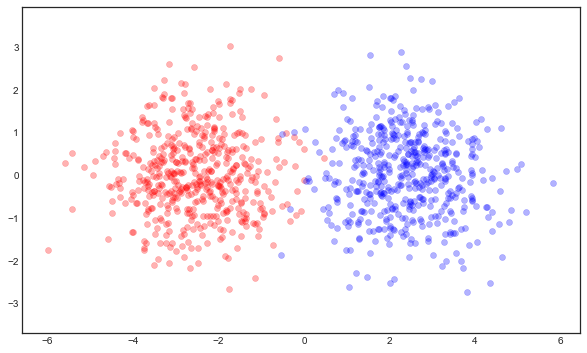

In [133]:
count = 500
sep = 5.

x = np.zeros((2, 2*count))
x[0,:] = np.concatenate((stats.norm(-sep/2., 1).rvs(count),
                        (stats.norm(sep/2., 1).rvs(count))))
x[1, :] = stats.norm(0, 1).rvs(2*count)
fig, ax = plt.subplots(figsize=(10,6))
ax.axis('equal')
ax.scatter(x[0, :count], x[1, :count], c='r', alpha=0.3)
ax.scatter(x[0, count:], x[1, count:], c='b', alpha=0.3)
plt.show()

### FIXME: there is a deprication warning for the chunk below. Not sure if we are concerned about this. Should probably tell students to expect it if we keep it.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


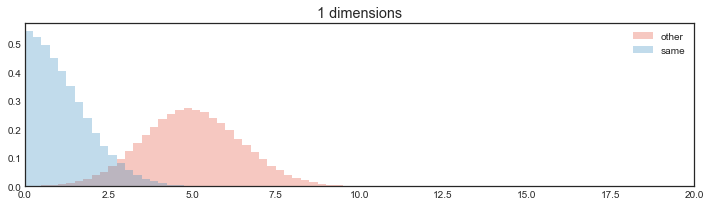

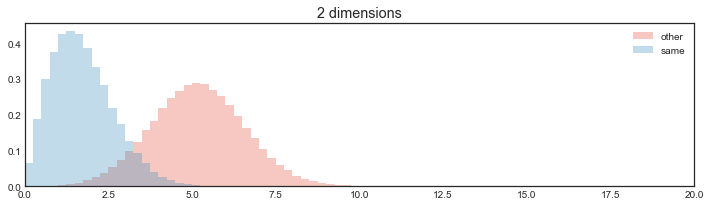

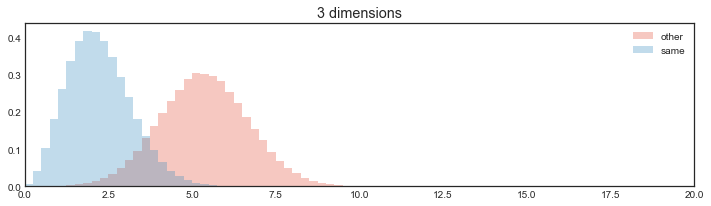

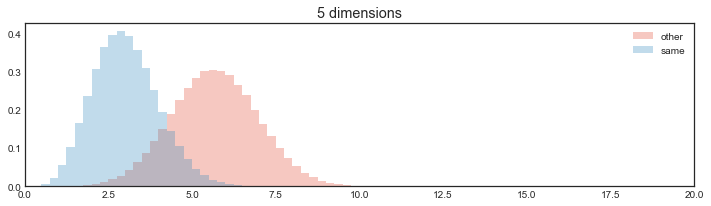

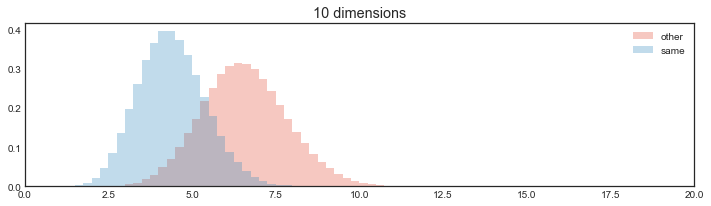

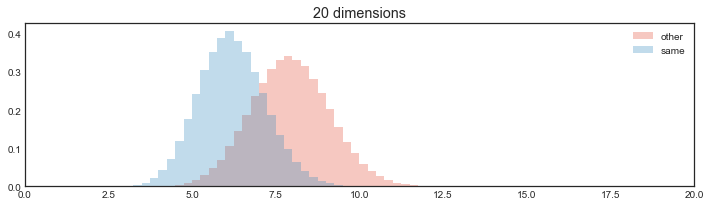

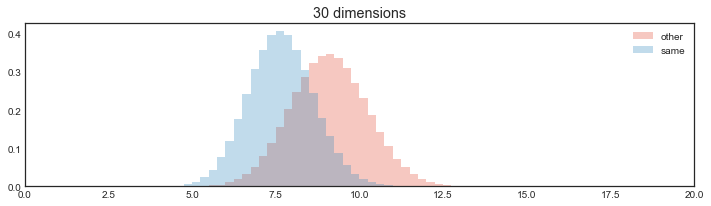

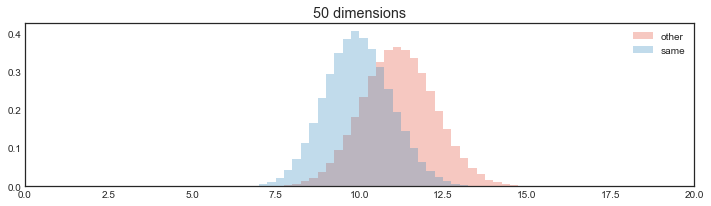

In [134]:
for dims in [1, 2, 3, 5, 10, 20, 30, 50]:
    x = np.zeros((dims, 2*count))
    x[0,:] = np.concatenate((stats.norm(-sep/2., 1).rvs(count),
                            (stats.norm(sep/2., 1).rvs(count))))
    for d in range(1, dims):
        x[d, :] = stats.norm(0, 1).rvs(2*count)

    clusterlabels = ["cluster 1"] * count + ["cluster 2"] * count 
    
    y = []
    dist = []
    for i in range(2*count):
        for j in range(i+1, 2*count):
            d = np.sqrt(sum((x[:,i] - x[:, j])**2))
            dist.append(d)
            y.append("same" if i // count == j // count else "other")
    multihist(np.array(dist), np.array(y), binsize=0.25, figsize=(12,3),
                   xmin=0, xmax=20, title="{0} dimensions".format(dims))
    #plt.axes(frameon=False)

    plt.show()

As the number of dimensions get large, the *every* point is far from its neighbors, even those in the same clusters. The differences between that and neighboring clusters is washed out.

That said, this assumes additional dimensions add nothing. What if each additional dimension adds an equal amount of signal?

### FIXME: there is a deprication warning for the chunk below. Not sure if we are concerned about this. Should probably tell students to expect it if we keep it.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


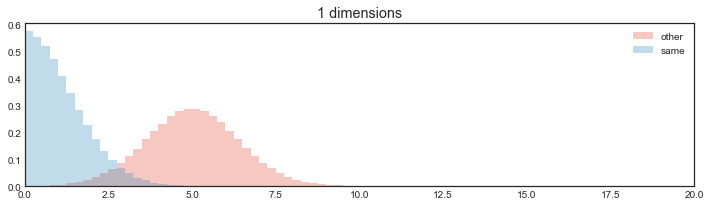

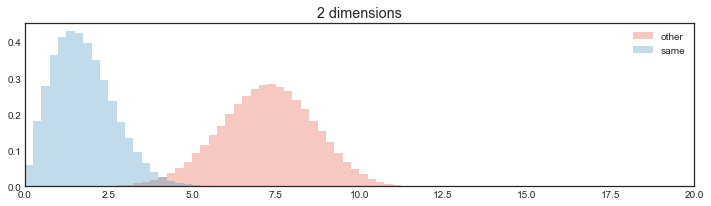

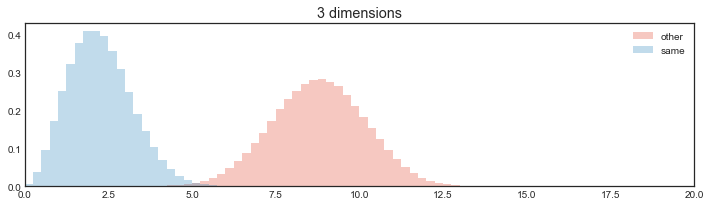

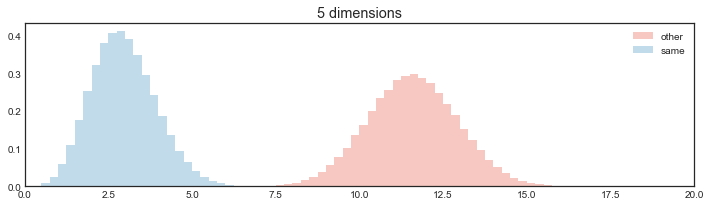

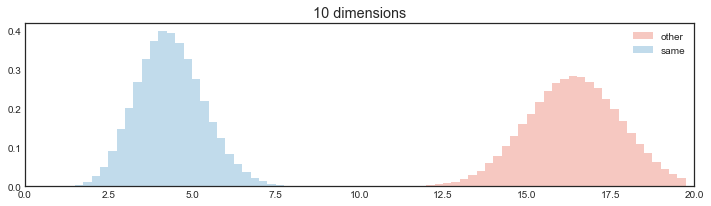

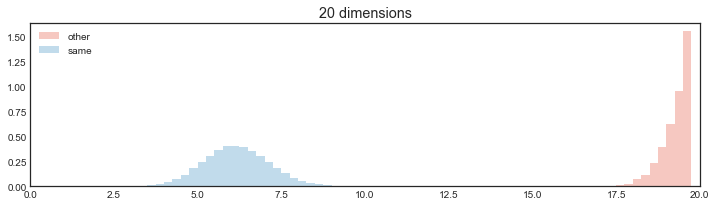

In [135]:
for dims in [1, 2, 3, 5, 10, 20]:
    
    x = np.zeros((dims, 2*count))
    for d in range(0, dims):
        x[d,:] = np.concatenate((stats.norm(-sep/2., 1).rvs(count),
                                (stats.norm(sep/2., 1).rvs(count))))

    clusterlabels = ["cluster 1"] * count + ["cluster 2"] * count 
    
    y = []
    dist = []
    for i in range(2*count):
        for j in range(i+1, 2*count):
            d = np.sqrt(sum((x[:,i] - x[:, j])**2))
            dist.append(d)
            y.append("same" if i // count == j // count else "other")
    multihist(np.array(dist), np.array(y), binsize=0.25, figsize=(12,3),
                   xmin=0, xmax=20, title="{0} dimensions".format(dims))
    #plt.axes(frameon=False)

    plt.show()

So here all the extra dimensions help, but that's not very realistic either. What if we assume that all these that each new dimension has an exponentially decreasing amount of signal.

Here additional dimension helps, but only up to a point. Later dimensions that are almost all noise make things worse.

### FIXME: there is a deprication warning for the chunk below. Not sure if we are concerned about this. Should probably tell students to expect it if we keep it.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


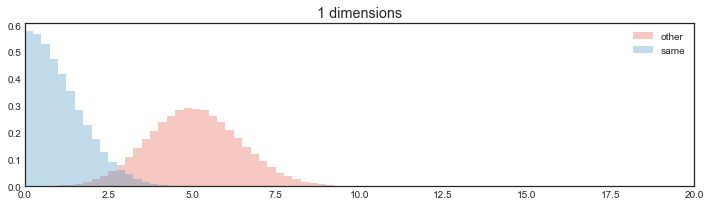

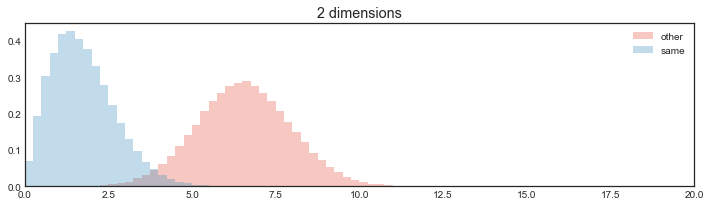

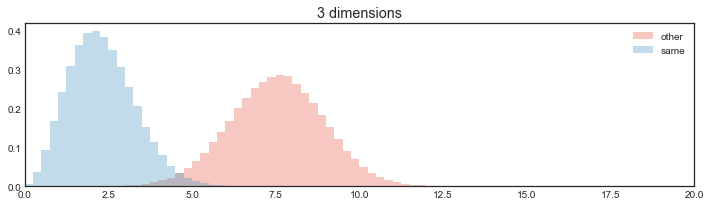

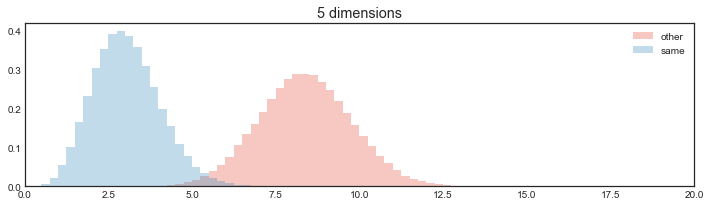

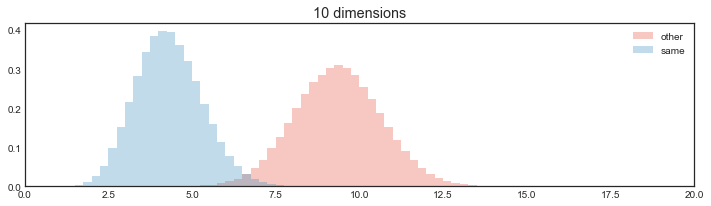

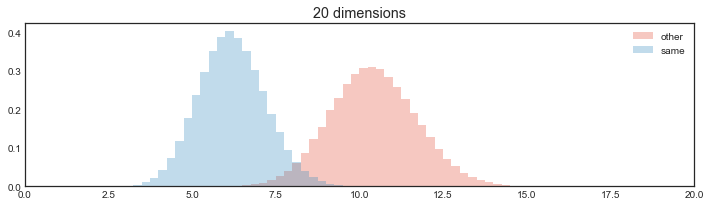

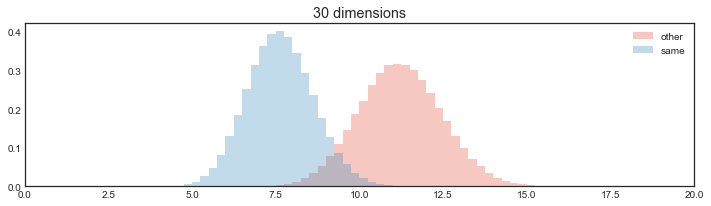

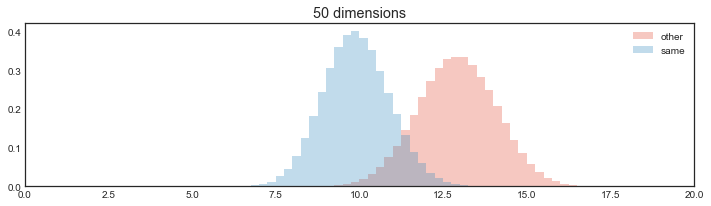

In [136]:
for dims in [1, 2, 3, 5, 10, 20, 30, 50]:
    
    x = np.zeros((dims, 2*count))
    for d in range(0, dims):
        x[d,:] = np.concatenate((stats.norm(-sep/2.*(.8**d), 1).rvs(count),
                                (stats.norm(sep/2.*(.8**d), 1).rvs(count))))
    
    clusterlabels = ["cluster 1"] * count + ["cluster 2"] * count 
    
    y = []
    dist = []
    for i in range(2*count):
        for j in range(i+1, 2*count):
            d = np.sqrt(sum((x[:,i] - x[:, j])**2))
            dist.append(d)
            y.append("same" if i // count == j // count else "other")
    multihist(np.array(dist), np.array(y), binsize=0.25, figsize=(12,3),
                   xmin=0, xmax=20, title="{0} dimensions".format(dims))
    #plt.axes(frameon=False)

    plt.show()

In high dimensions, points become extremely spare -- nothing is very near anything else, to where every point is a similar distance to every other. While you can achieve the same density in with more points, it takes a *lot* more.

__________
Notes (markdown):

In [ ]:
# Scratch area (code)

### FIXME: Need to create a wrap up section